# Exploratory data analysis with the Alibaba dataset

In this notebook, we attempt in understanding how groundtruth cluster profiles, based on metadata values, would look like.
To understand them, we evaluate how well the points fit in the groups, using the _silhouette_ measure.

In [2]:
import pandas as pd
import numpy as np

In [3]:
from dask.delayed import delayed
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
from scipy.stats import norm
import numpy as np

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
import hdbscan

In [9]:
import random

### Define functions

In [10]:
def plot_silhouette_results(cluster_labels, silhouette_avg, sample_silhouette_values, n_clusters, multiplier=10000, le_name_mapping=None):
    plt.figure(figsize=(12, 12))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #plt.ylim([0, len(scaled) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i 

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        if le_name_mapping:
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, le_name_mapping[i])
        else:
            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + multiplier  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-1., -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [11]:
def load_dd_delayed(keyword):
    with open('/data/clusterdata/cluster-trace-gpu-v2020/data/pai_%s.header' % keyword) as fin:
        lines = fin.readlines()
        col_names = lines[0].strip().split(',')

    col_names

    dfs = delayed(pd.read_csv)('/data/clusterdata/cluster-trace-gpu-v2020/data/pai_%s.tar.gz' % keyword, 
                               header=None, index_col=False, names=col_names, delimiter=',')

    dd_delayed = dd.from_delayed(dfs)

    return dd_delayed

In [12]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [13]:
def stratified_proportional_sampling(dataframe_in, filter_metric, filter_values, sampling_perc):
    target_vals = []
    for val in filter_values:
        val_array = dataframe_in[dataframe_in[filter_metric] == val].select_dtypes(include=np.number).fillna(0).values
        target_vals = target_vals + random.sample(list(val_array), int(val_array.shape[0] * sampling_perc))
    return target_vals

In [14]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df



def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


def __smpl_size(population, size):
    '''
    A function to compute the sample size. If not informed, a sampling 
    size will be calculated using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Parameters
    ----------
        :population: population size
        :size: sample size (default = None)
    Returns
    -------
    Calculated sample size to be used in the functions:
        - stratified_sample
        - stratified_sample_report
    '''
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

## Data Extraction

In [15]:
dd_delayed = load_dd_delayed('job_table')

In [16]:
job_df = dd_delayed.compute()

In [17]:
job_df

job_name  \
0               pai_job_table.csv   
1        9605ac7cc4c55a193fbe956b   
2        a2d8872d080eb634a42ea9a6   
3        e8baa72bfcd1b723cafab26a   
4        4e87f469c73e13613908b658   
...                           ...   
1055497  a155d69dca6bfd2dfb78ef0d   
1055498  e4e802c3b63829c1e2e3343b   
1055499  f11820cc3d678bcdc37faf08   
1055500  ee3480523c1bf79b0d02c260   
1055501                       NaN   

                                                   inst_id          user  \
0        38e2d7187762a9241cc1cd5732dbe52a5d8b37ed7dafe1...  74238accb90b   
1        e1cbdf28400847d65d00da4f0522ce7a43275fe9cb5d2a...  61d6b6dd5b15   
2        27ddabc2f7490279c6d5bd95c8a75e5c96d841c6030659...  61d6b6dd5b15   
3        70e4f598c8cdf40f24e0e7d3aba9a9dacde5342e1f2ffd...  61d6b6dd5b15   
4        5bb3500e7f1a42a9ce82544dad5f202547848e9727e221...  61d6b6dd5b15   
...                                                    ...           ...   
1055497  267c02fbda06c42fb83fc8034d2be1c51149127deb2292...  a4187a15253d   
1055498  37c6523c16f1574055fb637a82bb22a913122d58c8368a...  a4187a15253d   
1055499  d50242c89f3a25bd20ef700701777823c415ad0321dcb3...  a4187a15253d   
1055500  6c6338d4ac59fd1157e569fd6b5de6b70975c65112e9ba...  a4187a15253d   
1055501                                                NaN           NaN   

             status  start_time   end_time  
0           Running   1053513.0        NaN  
1           Running   1097614.0        NaN  
2           Running   1103820.0        NaN  
3        Terminated   1104396.0  1140852.0  
4        Terminated   1109911.0  1233527.0  
...             ...         ...        ...  
1055497  Terminated   6420116.0  6431658.0  
1055498     Running   6431847.0        NaN  
1055499  Terminated   6431859.0  6431872.0  
1055500  Terminated   6431969.0  6435635.0  
1055501         NaN         NaN        NaN  

[1055502 rows x 6 columns]

In [18]:
job_df.value_counts('status')

status
Terminated    732355
Failed        256555
Running        62928
Waiting         3663
dtype: int64

In [19]:
dd_delayed = load_dd_delayed('task_table')

In [20]:
task_df = dd_delayed.compute()

In [21]:
task_df[task_df.job_name == 'f11820cc3d678bcdc37faf08']

job_name      task_name  inst_num      status  \
840157  f11820cc3d678bcdc37faf08  PyTorchWorker       1.0  Terminated   

        start_time   end_time  plan_cpu  plan_mem  plan_gpu gpu_type  
840157   6431859.0  6431872.0    1800.0  58.59375     100.0     MISC

In [22]:
job_result_df = pd.merge(job_df[['job_name', 'inst_id', 'user']], task_df, on='job_name', how='inner')

In [23]:
job_result_df

job_name  \
0        9605ac7cc4c55a193fbe956b   
1        a2d8872d080eb634a42ea9a6   
2        e8baa72bfcd1b723cafab26a   
3        4e87f469c73e13613908b658   
4        dcf1bd23bb296a8efb35902b   
...                           ...   
1261044  a155d69dca6bfd2dfb78ef0d   
1261045  e4e802c3b63829c1e2e3343b   
1261046  f11820cc3d678bcdc37faf08   
1261047  ee3480523c1bf79b0d02c260   
1261048                       NaN   

                                                   inst_id          user  \
0        e1cbdf28400847d65d00da4f0522ce7a43275fe9cb5d2a...  61d6b6dd5b15   
1        27ddabc2f7490279c6d5bd95c8a75e5c96d841c6030659...  61d6b6dd5b15   
2        70e4f598c8cdf40f24e0e7d3aba9a9dacde5342e1f2ffd...  61d6b6dd5b15   
3        5bb3500e7f1a42a9ce82544dad5f202547848e9727e221...  61d6b6dd5b15   
4        4fe3a2e132a1ffd068bf3d6dca3906d24a37f95df2c98e...  61d6b6dd5b15   
...                                                    ...           ...   
1261044  267c02fbda06c42fb83fc8034d2be1c51149127deb2292...  a4187a15253d   
1261045  37c6523c16f1574055fb637a82bb22a913122d58c8368a...  a4187a15253d   
1261046  d50242c89f3a25bd20ef700701777823c415ad0321dcb3...  a4187a15253d   
1261047  6c6338d4ac59fd1157e569fd6b5de6b70975c65112e9ba...  a4187a15253d   
1261048                                                NaN           NaN   

             task_name  inst_num      status  start_time   end_time  plan_cpu  \
0               worker      20.0     Running   1097614.0        NaN       NaN   
1               worker     100.0     Running   1103820.0        NaN       NaN   
2               worker      20.0  Terminated   1104396.0  1140852.0     600.0   
3               worker      30.0  Terminated   1109911.0  1233527.0     600.0   
4               worker       5.0  Terminated   1129126.0  1129627.0     600.0   
...                ...       ...         ...         ...        ...       ...   
1261044    JupyterTask       1.0  Terminated   6420116.0  6431658.0     200.0   
1261045  PyTorchWorker       1.0     Running   6431847.0        NaN       NaN   
1261046  PyTorchWorker       1.0  Terminated   6431859.0  6431872.0    1800.0   
1261047    JupyterTask       1.0  Terminated   6431969.0  6435635.0     200.0   
1261048            NaN       NaN         NaN         NaN        NaN       NaN   

          plan_mem  plan_gpu gpu_type  
0              NaN       NaN     P100  
1              NaN       NaN     P100  
2        29.296875      50.0     MISC  
3        29.296875      50.0     MISC  
4        29.296875     100.0     MISC  
...            ...       ...      ...  
1261044   3.925781     100.0     MISC  
1261045        NaN       NaN      NaN  
1261046  58.593750     100.0     MISC  
1261047   3.925781     100.0     MISC  
1261048        NaN       NaN      NaN  

[1261049 rows x 12 columns]

In [24]:
job_result_df.value_counts('gpu_type')

gpu_type
MISC       696280
T4         226923
P100        72731
V100        28797
V100M32     18579
dtype: int64

In [25]:
dd_delayed = load_dd_delayed('group_tag_table')

In [26]:
group_tag_table_df = dd_delayed.compute()

In [27]:
group_tag_table_df

inst_id          user  \
0                                  pai_group_tag_table.csv  58540f191766   
1        a8c39faded8b9a5b7436a47aff747835795cec39ef33c7...  58540f191766   
2        26bf18df11f3a989fa64ed808dc780ab24a7700941f7c1...  58540f191766   
3        a4fdd0229b8fcc227a8828daaa37500a29e125c1c38d1c...  58540f191766   
4        4b4ab6c2a0691b35d8a9abb22ade8164b6be1bdb19c8a7...  58540f191766   
...                                                    ...           ...   
1055028  d072b733e39178d2f893e02ca46553b748afe9982789ff...  970063dba409   
1055029  b81b2e0033aa5a5e591b908fb92ec79a0ecbd8c69f174e...  16808c52c63a   
1055030  b8f69c79ceb61839dc74a742fddbb0e86f76b6d171f96c...  16808c52c63a   
1055031  701711437f4c950197e77f3c04ca23fa3bb6ac3c13dd25...  5a43fb583e5d   
1055032                                                NaN           NaN   

        gpu_type_spec                             group workload  
0                 NaN  ba4e3be6472ded359f4b1ca53d9bd53e      NaN  
1                 NaN  81b1eed4c4b0463b7e5a154f7c42db1e      NaN  
2                 NaN  046437ed700bdf7434aa88503cc97a8d      NaN  
3                 NaN  d50ee406f93d51ccf485b415861dd8f5      NaN  
4                 NaN  c5ee81877b36fdb5dac829aab7b4146a      NaN  
...               ...                               ...      ...  
1055028           NaN  fef6c044de369ba2bf168077064de744      NaN  
1055029           NaN  7953bc96f287acc3cc7113e1aac89eed      NaN  
1055030           NaN  a98575bef3fc5450b8a8b531d60dee7b      NaN  
1055031           NaN  1e32bc94f785407bea8179f77ae6152a      NaN  
1055032           NaN                               NaN      NaN  

[1055033 rows x 5 columns]

In [28]:
group_tag_table_df.value_counts('workload')

workload
bert          54887
ctr           27083
nmt           10363
inception      5440
graphlearn     3754
resnet          541
xlnet           415
rl              249
vgg              66
dtype: int64

In [29]:
job_result_df = pd.merge(job_result_df, group_tag_table_df[['inst_id', 'group', 'workload']], on='inst_id', how='inner')

In [30]:
selected_df = job_result_df[(job_result_df.status == 'Terminated') & (job_result_df.workload.notnull())]

In [31]:
selected_df

job_name  \
515      5c69dd716653aa7be6ee77d3   
522      45bfe885631d2fc0f67c2b87   
537      762dade1375e5d7f06c3d637   
549      490fa420639aa44fd5b5b463   
553      f24b418960c0f671a7966499   
...                           ...   
1259058  bb86a612f4d545c5fb8836d6   
1259123  0f7e4da20d407697e34506ee   
1259124  0f7e4da20d407697e34506ee   
1259155  7ff3e872b8be51537beeefde   
1259158  f11820cc3d678bcdc37faf08   

                                                   inst_id          user  \
515      83a28b86769dfb487f5eea1589862ac8269280a11f8191...  33e4fcf3d314   
522      d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...  33e4fcf3d314   
537      23d6227dd31bb8affa714bb4ecacaa58d489aabb4a69c4...  33e4fcf3d314   
549      ae24a5194751c539ed3602978ecfab45eb1f6cb757c0b6...  33e4fcf3d314   
553      a79834dd88d13c47ca49c2b8544ccd529fa1a4598ead63...  33e4fcf3d314   
...                                                    ...           ...   
1259058  7285648549a5bf5b2d8768428a4fbe1b842baf8dd52da7...  a4187a15253d   
1259123  b43221ac6e39770df96b525ebba683a77a1772d564ed47...  61fabd2b354d   
1259124  b43221ac6e39770df96b525ebba683a77a1772d564ed47...  61fabd2b354d   
1259155  b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...  a4187a15253d   
1259158  d50242c89f3a25bd20ef700701777823c415ad0321dcb3...  a4187a15253d   

               task_name  inst_num      status  start_time   end_time  \
515               worker       2.0  Terminated   5452836.0  5452939.0   
522               worker       5.0  Terminated   5461078.0  5461299.0   
537               worker       8.0  Terminated   5474754.0  5476760.0   
549               worker      30.0  Terminated   5482097.0  5482459.0   
553               worker      30.0  Terminated   5483829.0  5484732.0   
...                  ...       ...         ...         ...        ...   
1259058  TensorboardTask       1.0  Terminated   5722718.0  5743470.0   
1259123           worker      20.0  Terminated   6061748.0  6064190.0   
1259124               ps      10.0  Terminated   6060811.0  6064207.0   
1259155    PyTorchWorker       1.0  Terminated   6419719.0  6421606.0   
1259158    PyTorchWorker       1.0  Terminated   6431859.0  6431872.0   

         plan_cpu   plan_mem  plan_gpu gpu_type  \
515         600.0  29.296875     100.0     V100   
522         600.0  29.296875     100.0     MISC   
537         600.0  29.296875     100.0     MISC   
549         600.0  29.296875     100.0     MISC   
553         600.0  29.296875     100.0     MISC   
...           ...        ...       ...      ...   
1259058     100.0   1.972656       NaN      NaN   
1259123     600.0  29.296875     100.0     P100   
1259124     600.0  29.296875       NaN      NaN   
1259155    1800.0  58.593750     100.0     MISC   
1259158    1800.0  58.593750     100.0     MISC   

                                    group    workload  
515      fbe13e29cea9d8c18612964c786ab0d7        bert  
522      fbe13e29cea9d8c18612964c786ab0d7        bert  
537      fbe13e29cea9d8c18612964c786ab0d7        bert  
549      fbe13e29cea9d8c18612964c786ab0d7        bert  
553      a91d89e7b403037001204c45a17a7a9a        bert  
...                                   ...         ...  
1259058  38dd1e31c5d5e26e7da460dbf799f6c7        bert  
1259123  ff0f23df0fc88304a6138e69723ba320  graphlearn  
1259124  ff0f23df0fc88304a6138e69723ba320  graphlearn  
1259155  cd3e061c2953d442747217685b8cd059        bert  
1259158  b1f76999830c0b710a504c9c6682464d        bert  

[129761 rows x 14 columns]

In [32]:
dd_delayed = load_dd_delayed('instance_table')

In [33]:
instance_df = dd_delayed.compute()

In [34]:
selected_df = pd.merge(selected_df, instance_df[['inst_id', 'inst_name', 'worker_name', 'machine']], on='inst_id', how='inner')

In [35]:
selected_df

job_name  \
0        5c69dd716653aa7be6ee77d3   
1        5c69dd716653aa7be6ee77d3   
2        45bfe885631d2fc0f67c2b87   
3        45bfe885631d2fc0f67c2b87   
4        45bfe885631d2fc0f67c2b87   
...                           ...   
1615871  0f7e4da20d407697e34506ee   
1615872  7ff3e872b8be51537beeefde   
1615873  7ff3e872b8be51537beeefde   
1615874  7ff3e872b8be51537beeefde   
1615875  f11820cc3d678bcdc37faf08   

                                                   inst_id          user  \
0        83a28b86769dfb487f5eea1589862ac8269280a11f8191...  33e4fcf3d314   
1        83a28b86769dfb487f5eea1589862ac8269280a11f8191...  33e4fcf3d314   
2        d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...  33e4fcf3d314   
3        d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...  33e4fcf3d314   
4        d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...  33e4fcf3d314   
...                                                    ...           ...   
1615871  b43221ac6e39770df96b525ebba683a77a1772d564ed47...  61fabd2b354d   
1615872  b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...  a4187a15253d   
1615873  b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...  a4187a15253d   
1615874  b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...  a4187a15253d   
1615875  d50242c89f3a25bd20ef700701777823c415ad0321dcb3...  a4187a15253d   

             task_name  inst_num      status  start_time   end_time  plan_cpu  \
0               worker       2.0  Terminated   5452836.0  5452939.0     600.0   
1               worker       2.0  Terminated   5452836.0  5452939.0     600.0   
2               worker       5.0  Terminated   5461078.0  5461299.0     600.0   
3               worker       5.0  Terminated   5461078.0  5461299.0     600.0   
4               worker       5.0  Terminated   5461078.0  5461299.0     600.0   
...                ...       ...         ...         ...        ...       ...   
1615871             ps      10.0  Terminated   6060811.0  6064207.0     600.0   
1615872  PyTorchWorker       1.0  Terminated   6419719.0  6421606.0    1800.0   
1615873  PyTorchWorker       1.0  Terminated   6419719.0  6421606.0    1800.0   
1615874  PyTorchWorker       1.0  Terminated   6419719.0  6421606.0    1800.0   
1615875  PyTorchWorker       1.0  Terminated   6431859.0  6431872.0    1800.0   

          plan_mem  plan_gpu gpu_type                             group  \
0        29.296875     100.0     V100  fbe13e29cea9d8c18612964c786ab0d7   
1        29.296875     100.0     V100  fbe13e29cea9d8c18612964c786ab0d7   
2        29.296875     100.0     MISC  fbe13e29cea9d8c18612964c786ab0d7   
3        29.296875     100.0     MISC  fbe13e29cea9d8c18612964c786ab0d7   
4        29.296875     100.0     MISC  fbe13e29cea9d8c18612964c786ab0d7   
...            ...       ...      ...                               ...   
1615871  29.296875       NaN      NaN  ff0f23df0fc88304a6138e69723ba320   
1615872  58.593750     100.0     MISC  cd3e061c2953d442747217685b8cd059   
1615873  58.593750     100.0     MISC  cd3e061c2953d442747217685b8cd059   
1615874  58.593750     100.0     MISC  cd3e061c2953d442747217685b8cd059   
1615875  58.593750     100.0     MISC  b1f76999830c0b710a504c9c6682464d   

           workload                                          inst_name  \
0              bert  d6eeb326a6ac4e4cfa2968387009ed6fa7a11b0ea004ae...   
1              bert  35e48c238a3a44df8402b8051e181efea509fd1ee22e7f...   
2              bert  2adb8f689b8e9e21923996e1f05698470f047956089914...   
3              bert  79a1edb34552f3e7a3b197827c7dd2dea1b1b2f5ec218c...   
4              bert  d5ad8cd6f89dea6a07337dd12b80ca208be4129b24fecf...   
...             ...                                                ...   
1615871  graphlearn  932aa55a40ebc2cf34857aa6de18e109e065b897e8db06...   
1615872        bert  ec3a0cf96ee7be24c461b1132a3d1b185c5812ca309fdd...   
1615873        bert  ec3a0cf96ee7be24c461b1132a3d1b185c5812ca309fdd...   
1615874        bert  ec3a0cf96ee7be24c461b1132a3d1b18

In [36]:
selected_df.value_counts(['task_name', 'workload'])

task_name          workload  
ps                 ctr           324698
worker             ctr           310884
                   bert          239376
ps                 inception     198623
worker             inception     198077
evaluator          ctr            84484
worker             graphlearn     70336
ps                 graphlearn     70327
                   bert           53947
tensorflow         bert           22248
PyTorchWorker      bert           10746
                   nmt             8535
worker             rl              6019
tensorflow         ctr             4032
ps                 resnet          2449
worker             resnet          2379
evaluator          bert            2086
ps                 xlnet           1750
worker             xlnet           1750
                   nmt              892
PyTorchWorker      rl               489
TensorboardTask    bert             445
OssToVolumeWorker  bert             208
worker             vgg              193
ps        

In [37]:
dd_delayed = load_dd_delayed('sensor_table')

In [38]:
sensor_df = dd_delayed.compute()

In [39]:
sensor_df.columns

Index(['job_name', 'task_name', 'worker_name', 'inst_id', 'machine',
       'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem',
       'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count',
       'write_count'],
      dtype='object')

In [40]:
selected_df = pd.merge(selected_df, sensor_df[['inst_id', 'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem',
                                              'read', 'write', 'read_count', 'write_count']], on='inst_id', how='inner')

In [41]:
selected_df

job_name  \
0         5c69dd716653aa7be6ee77d3   
1         5c69dd716653aa7be6ee77d3   
2         45bfe885631d2fc0f67c2b87   
3         45bfe885631d2fc0f67c2b87   
4         45bfe885631d2fc0f67c2b87   
...                            ...   
36690180  0f7e4da20d407697e34506ee   
36690181  7ff3e872b8be51537beeefde   
36690182  7ff3e872b8be51537beeefde   
36690183  7ff3e872b8be51537beeefde   
36690184  f11820cc3d678bcdc37faf08   

                                                    inst_id          user  \
0         83a28b86769dfb487f5eea1589862ac8269280a11f8191...  33e4fcf3d314   
1         83a28b86769dfb487f5eea1589862ac8269280a11f8191...  33e4fcf3d314   
2         d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...  33e4fcf3d314   
3         d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...  33e4fcf3d314   
4         d61dd48fcecea78ffce62735d6b728371fa35a5697f1b1...  33e4fcf3d314   
...                                                     ...           ...   
36690180  b43221ac6e39770df96b525ebba683a77a1772d564ed47...  61fabd2b354d   
36690181  b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...  a4187a15253d   
36690182  b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...  a4187a15253d   
36690183  b99050ffacf3f321400a836d0e9f9183d49fa4b695aada...  a4187a15253d   
36690184  d50242c89f3a25bd20ef700701777823c415ad0321dcb3...  a4187a15253d   

              task_name  inst_num      status  start_time   end_time  \
0                worker       2.0  Terminated   5452836.0  5452939.0   
1                worker       2.0  Terminated   5452836.0  5452939.0   
2                worker       5.0  Terminated   5461078.0  5461299.0   
3                worker       5.0  Terminated   5461078.0  5461299.0   
4                worker       5.0  Terminated   5461078.0  5461299.0   
...                 ...       ...         ...         ...        ...   
36690180             ps      10.0  Terminated   6060811.0  6064207.0   
36690181  PyTorchWorker       1.0  Terminated   6419719.0  6421606.0   
36690182  PyTorchWorker       1.0  Terminated   6419719.0  6421606.0   
36690183  PyTorchWorker       1.0  Terminated   6419719.0  6421606.0   
36690184  PyTorchWorker       1.0  Terminated   6431859.0  6431872.0   

          plan_cpu   plan_mem  ...   cpu_usage gpu_wrk_util   avg_mem  \
0            600.0  29.296875  ...   69.777778     0.000000  1.640234   
1            600.0  29.296875  ...   69.777778     0.000000  1.640234   
2            600.0  29.296875  ...   54.809524     0.000000  1.247226   
3            600.0  29.296875  ...   50.717949     0.142857  1.085914   
4            600.0  29.296875  ...   49.675676     0.300000  1.247371   
...            ...        ...  ...         ...          ...       ...   
36690180     600.0  29.296875  ...   22.776573     0.659483  2.635780   
36690181    1800.0  58.593750  ...  112.500000     0.000000  0.329102   
36690182    1800.0  58.593750  ...  112.500000     0.000000  0.329102   
36690183    1800.0  58.593750  ...  112.500000     0.000000  0.329102   
36690184    1800.0  58.593750  ...   73.000000     0.000000  0.143555   

           max_mem avg_gpu_wrk_mem max_gpu_wrk_mem          read  \
0         3.710938        0.921131        4.491211  2.042608e+08   
1         3.710938        0.921131        4.491211  2.042608e+08   
2         3.289062        0.597346        4.247070  1.690996e+08   
3         3.067383        0.572289        4.247070  1.797683e+08   
4         3.296875        0.600903        4.247070  2.183072e+08   
...            ...             ...             ...           ...   
36690180  2.951172        1.276226        1.344727  8.364573e+05   
36690181  0.641602        0.000000        0.000000  1.696908e+08   
36690182  0.641602        0.000000        0.000000  1.696908e+08   
36690183  0.641602        0.000000        0.000000  1.696908e+08   
36690184  0.270508        0.000000        0.000000  6.101400e+07   

                 write    read_count   write_count  
0         1.574263e+08  12103.81

In [42]:
selected_df['runtime'] = selected_df.end_time - selected_df.start_time

In [43]:
selected_df.rename(columns={'runtime': 'duration'}, inplace=True)

In [44]:
list(selected_df.select_dtypes(include=[np.number]).columns.values)

['inst_num',
 'start_time',
 'end_time',
 'plan_cpu',
 'plan_mem',
 'plan_gpu',
 'cpu_usage',
 'gpu_wrk_util',
 'avg_mem',
 'max_mem',
 'avg_gpu_wrk_mem',
 'max_gpu_wrk_mem',
 'read',
 'write',
 'read_count',
 'write_count',
 'duration']

In [45]:
selected_df.shape

(36690185, 29)

5.022733503179301 0.2670885415268416


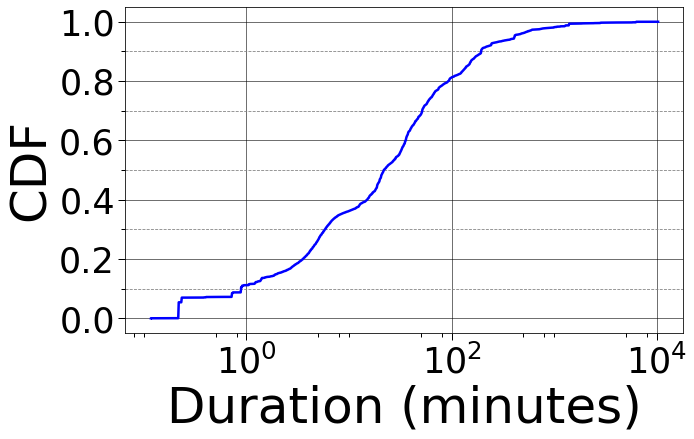

In [53]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import MultipleLocator,LogLocator, NullFormatter

input_x = selected_df.duration.values / 60
ecdf = ECDF(input_x)

x = np.logspace(np.log10(min(input_x)), np.log10(max(input_x)), 1_000)

y = ecdf(x)

x = np.concatenate( (np.array([min(input_x)]), x) )
y = np.concatenate( (np.array([0]), y) )

idx = np.abs(x - 5).argmin()
print(x[idx], y[idx])

fig, ax = plt.subplots(figsize=(10,6))


plt.plot(x, y, linewidth=2.5, color='blue')
plt.xscale('log')

ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter('{x:.1f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

locmin = LogLocator(base=10.0,subs=(0.1,0.5,0.8), numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(NullFormatter())


plt.grid(axis='both', which='major', color='k', alpha=0.7, linestyle='-')
plt.grid(axis='y', which='minor', color='grey', linestyle='--')

plt.xlabel(r'Duration (minutes)', fontsize=50)
plt.ylabel(r'CDF', fontsize=50)

plt.tick_params(which='major', width=1, length=7, labelsize=35)
plt.tick_params(which='minor', width=1, length=4)



plt.savefig('Figures/NSDI_paper/CDF_duration-allworkload-37M.pdf', format='pdf', bbox_inches='tight')

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
std_scaler = StandardScaler()

Compute runtime

In [505]:
selected_usage_df = selected_df[list(selected_df.select_dtypes(include=[np.number]).columns.values) #['cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count', 'write_count', 'runtime']
                               ].fillna(0,)

In [506]:
selected_usage_normalized = std_scaler.fit_transform(selected_usage_df)

In [507]:
selected_usage_normalized.shape

(36690185, 17)

## Sample according to _Workload_ feature

In [508]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(selected_df.workload)
y = le.transform(selected_df.workload)

In [509]:
stratified_sample_report(selected_df, ['workload'], 100000)

<ipython-input-50-fc366d77c775>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['size'] = 1


workload      size  samp_size
0        bert  10940142      29818
1         ctr   9128957      24881
2  graphlearn   4888371      13323
3   inception  10781289      29385
4         nmt     13537         37
5      resnet     60863        166
6          rl    849626       2316
7         vgg     11768         32
8       xlnet     15632         43

In [510]:
examples_sampled = stratified_sample(selected_df, ['workload'], size=100000, seed=123, keep_index= True)


<ipython-input-50-fc366d77c775>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['size'] = 1


In [517]:
examples_sampled_usage_df = examples_sampled[list(selected_df.select_dtypes(include=[np.number]).columns.values)  #['cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem','read', 'write', 'read_count', 'write_count', 'runtime']
].fillna(0,)

In [929]:
examples_sampled_usage_df.to_csv("/data/clusterdata/cluster-trace-gpu-v2020/samples/workload-100_000-usage.csv")

ModuleNotFoundError: No module named 'pandas.io.formats.csvs'

In [930]:
std_scaler = StandardScaler()

In [931]:
selected_usage_normalized = std_scaler.fit_transform(examples_sampled_usage_df)

In [932]:
selected_usage_normalized.shape

(100001, 17)

## Analyze the *Workload* feature

In [521]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(examples_sampled.workload)
y = le.transform(examples_sampled.workload)

In [522]:
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))

In [523]:
le_name_mapping

{0: 'bert',
 1: 'ctr',
 2: 'graphlearn',
 3: 'inception',
 4: 'nmt',
 5: 'resnet',
 6: 'rl',
 7: 'vgg',
 8: 'xlnet'}

In [524]:
len(set(y))

9

### Overall results (using all features)

#### Using **euclidean distance**

In [525]:
sample_silhouette_values = silhouette_samples(selected_usage_normalized, y)

In [526]:
sample_silhouette_values.mean()

0.16673321311202638

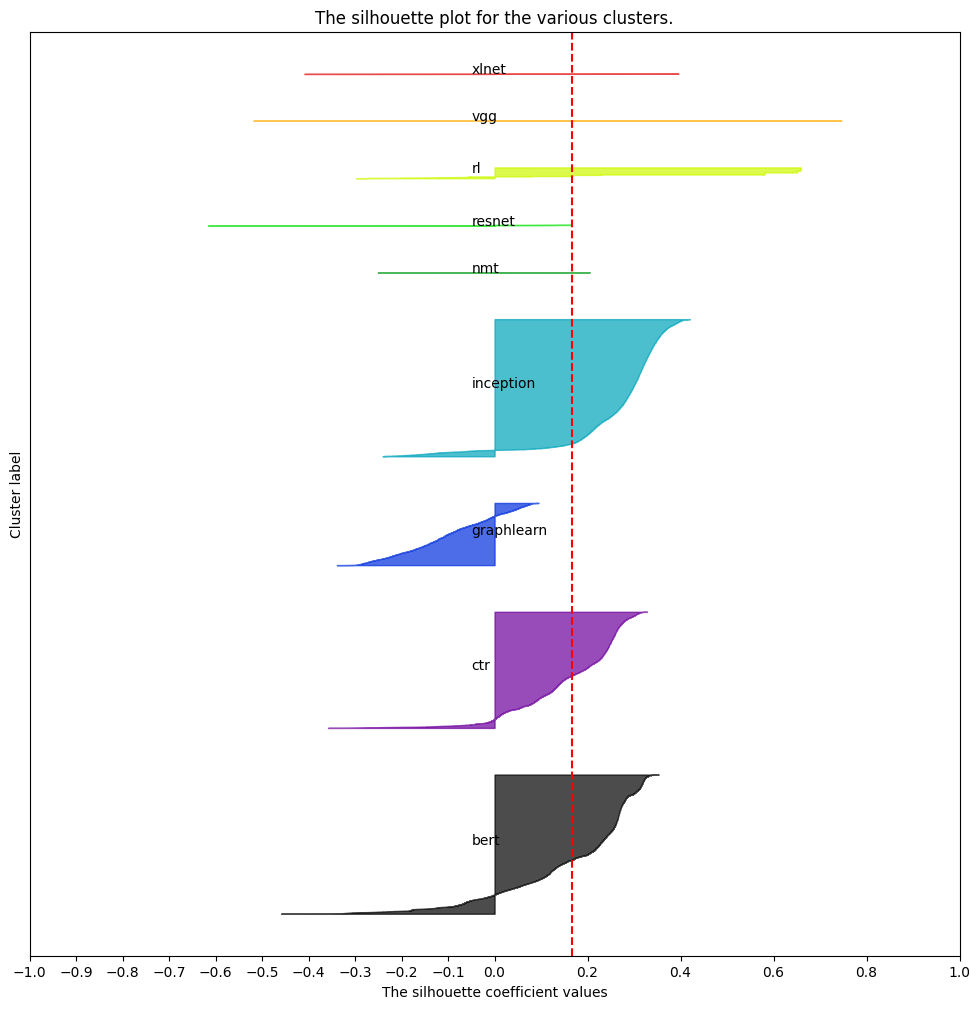

In [527]:
plot_silhouette_results(y, sample_silhouette_values.mean(), sample_silhouette_values, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

#### Using **cosine distance**

In [528]:
sample_silhouette_values_cosine = silhouette_samples(selected_usage_normalized, y, metric='cosine')

In [529]:
sample_silhouette_values_cosine.mean()

0.03335850088004906

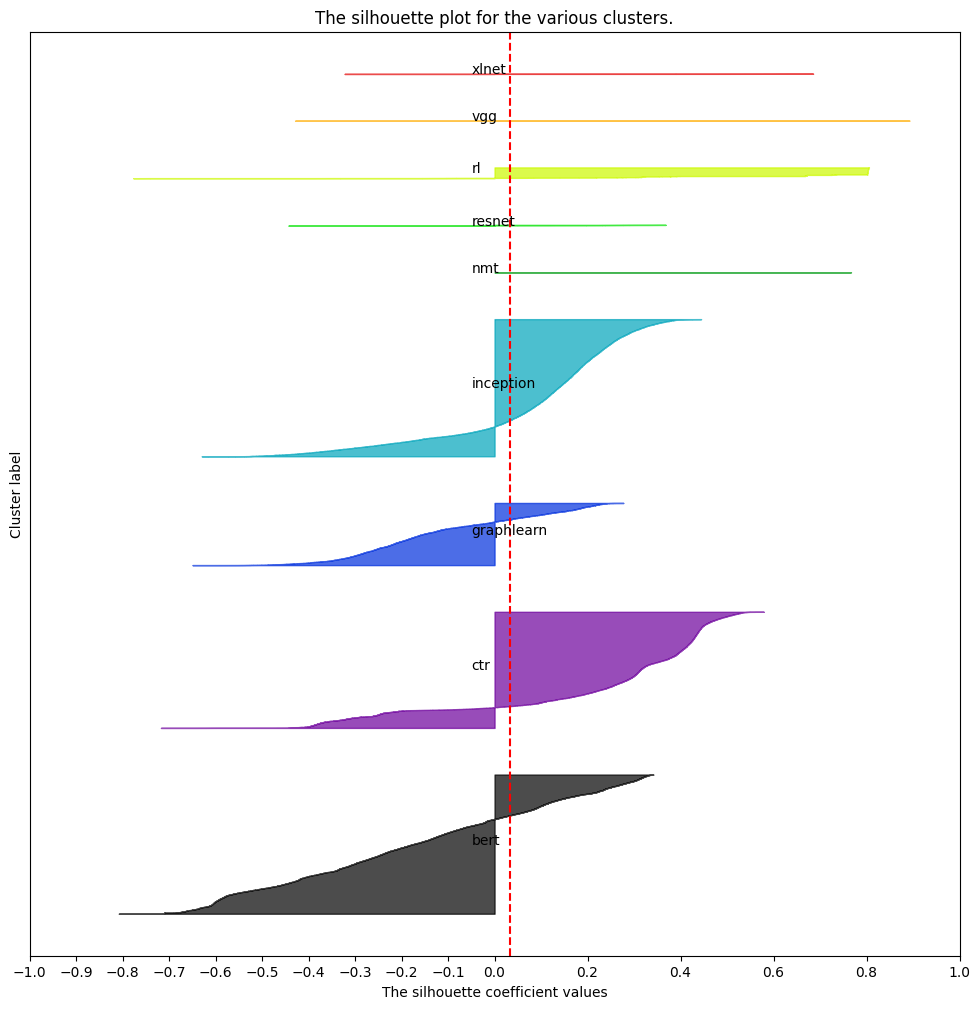

In [530]:
plot_silhouette_results(y, sample_silhouette_values_cosine.mean(), sample_silhouette_values_cosine, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

#### Using **manhattan distance**

https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6

In [531]:
sample_silhouette_values_manhattan = silhouette_samples(selected_usage_normalized, y, metric='manhattan')

In [532]:
sample_silhouette_values_manhattan.mean()

0.21496681722786268

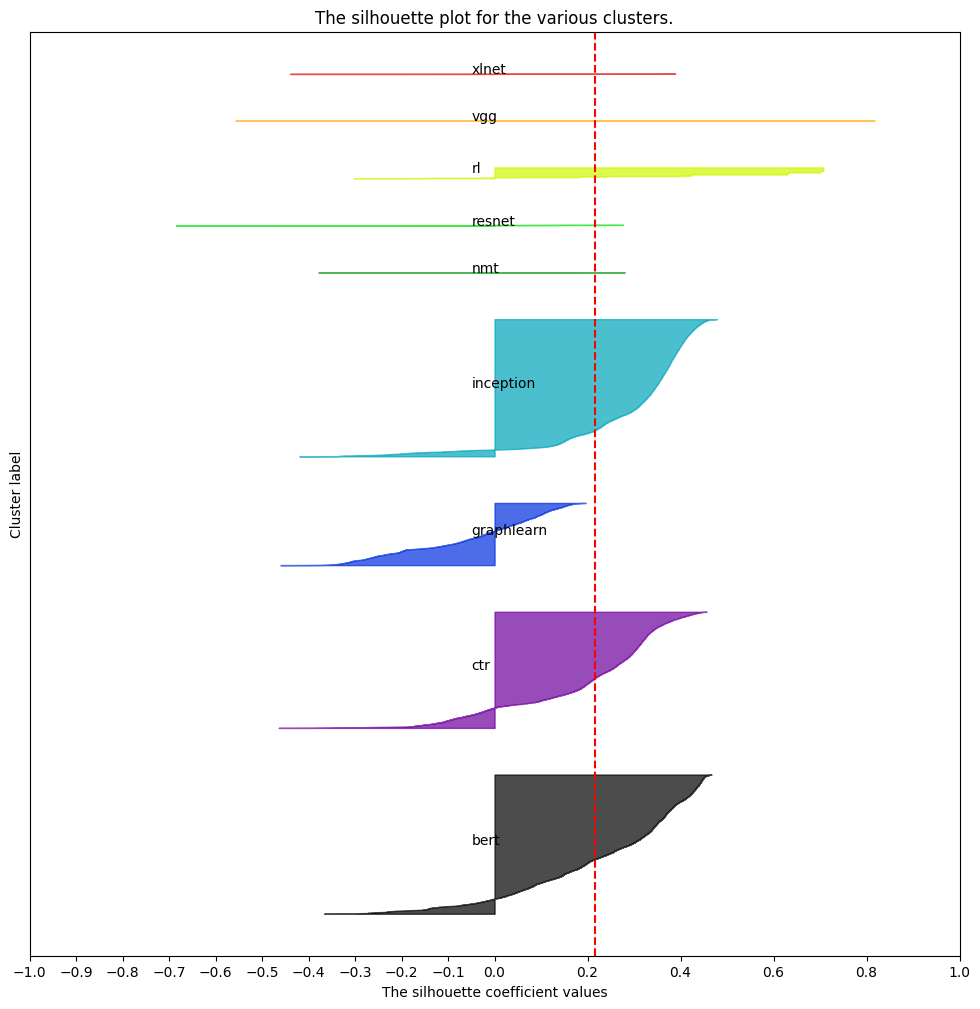

In [533]:
plot_silhouette_results(y, sample_silhouette_values_manhattan.mean(), sample_silhouette_values_manhattan, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### cpu_usage

#### Using **euclidean distance**

In [88]:
sample_silhouette_values_0 = silhouette_samples(selected_usage_normalized[:,0:1], y)

In [89]:
sample_silhouette_values_0.mean()

-0.5063482856961484

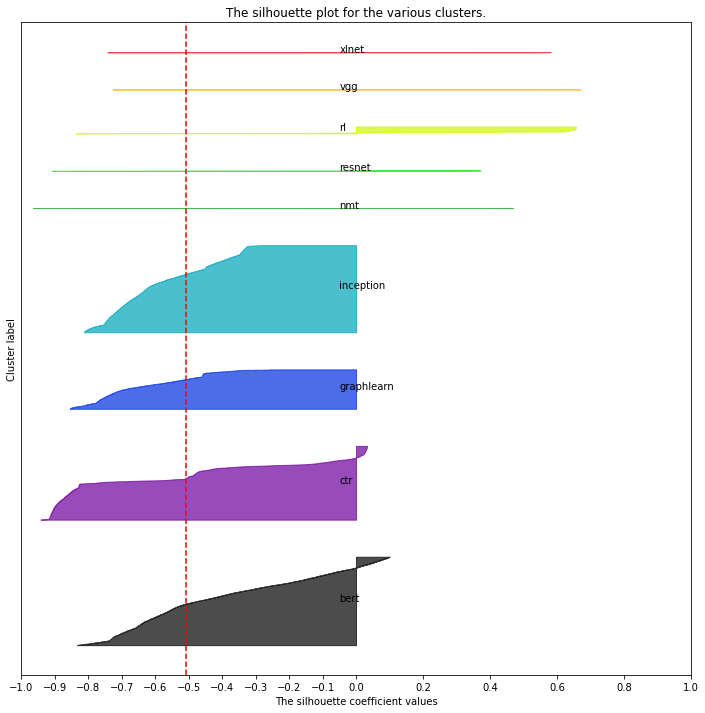

In [97]:
plot_silhouette_results(y, sample_silhouette_values_0.mean(), sample_silhouette_values_0, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### gpu_wrk_util

#### Using **euclidean distance**

In [92]:
sample_silhouette_values_1 = silhouette_samples(selected_usage_normalized[:,1:2], y)

In [93]:
sample_silhouette_values_1.mean()

-0.307821759521102

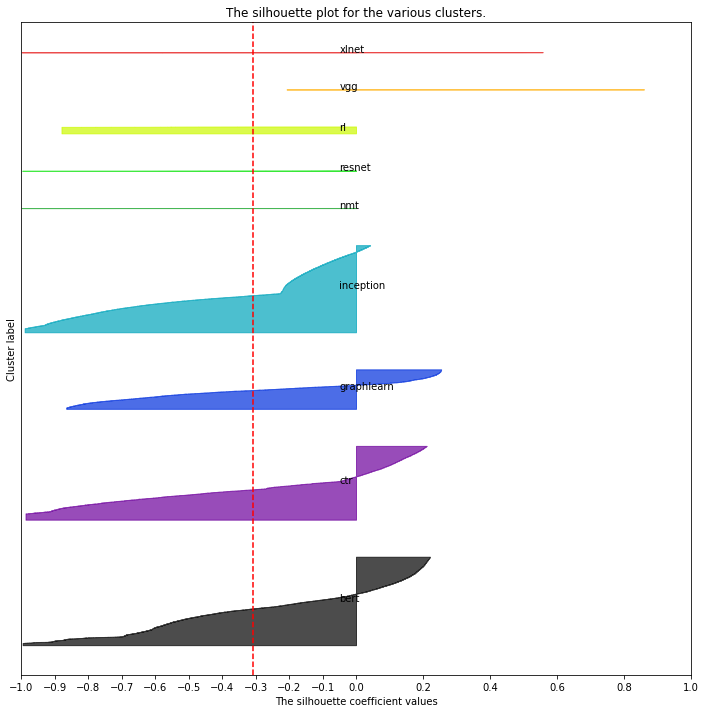

In [98]:
plot_silhouette_results(y, sample_silhouette_values_1.mean(), sample_silhouette_values_1, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### avg_mem

#### Using **euclidean distance**

In [99]:
sample_silhouette_values_2 = silhouette_samples(selected_usage_normalized[:,2:3], y)

In [100]:
sample_silhouette_values_2.mean()

-0.3916037162067184

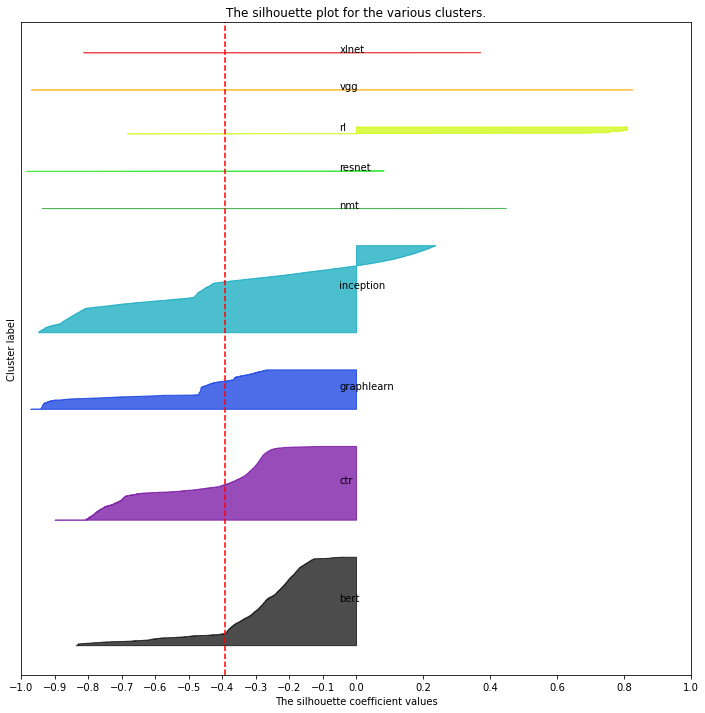

In [101]:
plot_silhouette_results(y, sample_silhouette_values_2.mean(), sample_silhouette_values_2, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### max_mem

#### Using **euclidean distance**

In [102]:
sample_silhouette_values_3 = silhouette_samples(selected_usage_normalized[:,3:4], y)

In [103]:
sample_silhouette_values_3.mean()

0.010042761999647402

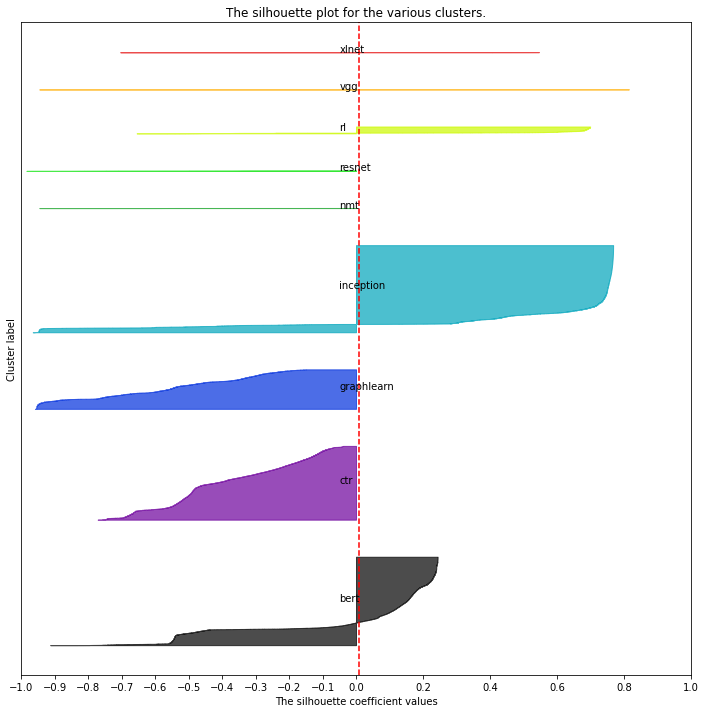

In [104]:
plot_silhouette_results(y, sample_silhouette_values_3.mean(), sample_silhouette_values_3, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### avg_gpu_wrk_mem

#### Using **euclidean distance**

In [105]:
sample_silhouette_values_4 = silhouette_samples(selected_usage_normalized[:,4:5], y)

In [106]:
sample_silhouette_values_4.mean()

-0.22332420959968466

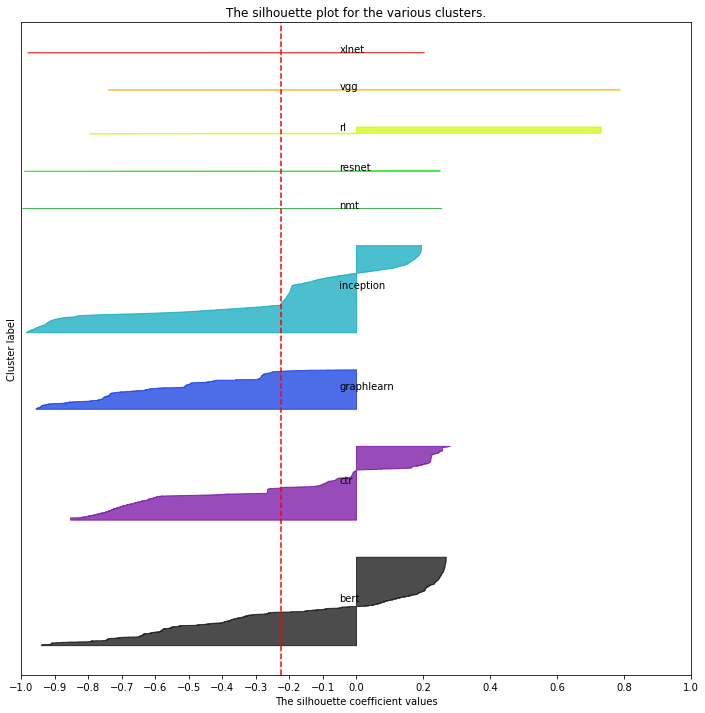

In [107]:
plot_silhouette_results(y, sample_silhouette_values_4.mean(), sample_silhouette_values_4, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### max_gpu_wrk_mem

#### Using **euclidean distance**

In [108]:
sample_silhouette_values_5 = silhouette_samples(selected_usage_normalized[:,5:6], y)

In [109]:
sample_silhouette_values_5.mean()

0.14261949278830038

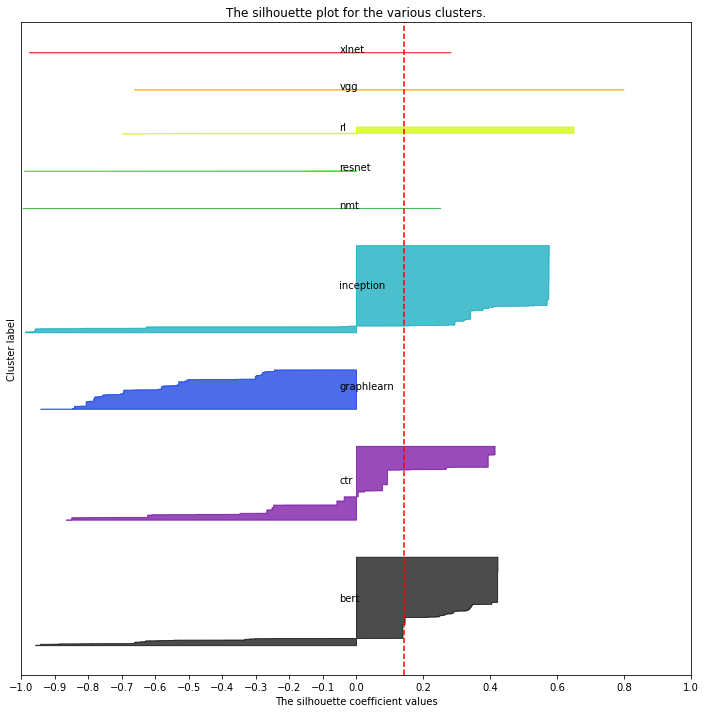

In [110]:
plot_silhouette_results(y, sample_silhouette_values_5.mean(), sample_silhouette_values_5, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

#### Using **cosine distance**

In [217]:
sample_silhouette_values_5_cosine = silhouette_samples(selected_usage_normalized[:,5:6], y, metric='cosine')

In [218]:
sample_silhouette_values_5_cosine.mean()

-0.5257321202766406

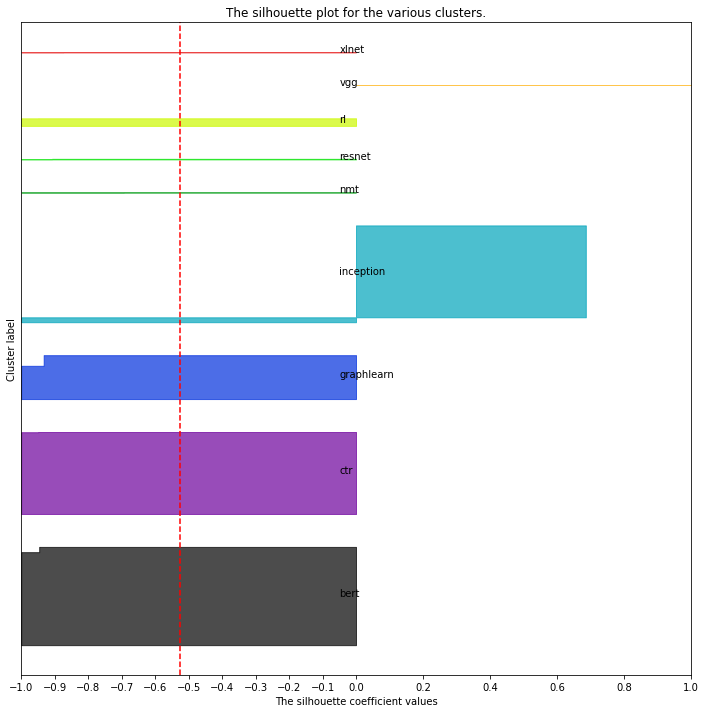

In [219]:
plot_silhouette_results(y, sample_silhouette_values_5_cosine.mean(), sample_silhouette_values_5_cosine, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

#### Using **manhattan distance**

In [214]:
sample_silhouette_values_5_manhattan = silhouette_samples(selected_usage_normalized[:,5:6], y, metric='manhattan')

In [215]:
sample_silhouette_values_5_manhattan.mean()

0.1350207499606006

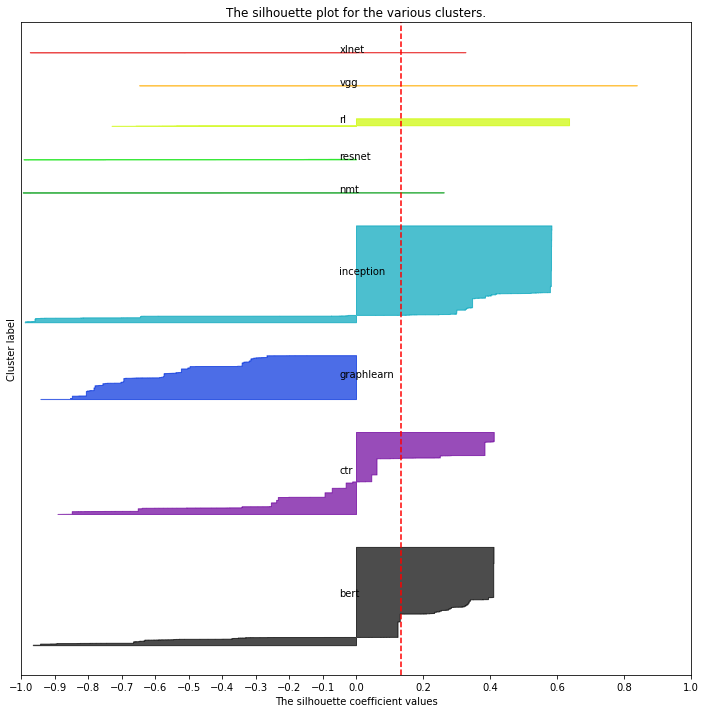

In [216]:
plot_silhouette_results(y, sample_silhouette_values_5_manhattan.mean(), sample_silhouette_values_5_manhattan, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### read

#### Using **euclidean distance**

In [111]:
sample_silhouette_values_6 = silhouette_samples(selected_usage_normalized[:,6:7], y)

In [112]:
sample_silhouette_values_6.mean()

-0.4001741179934693

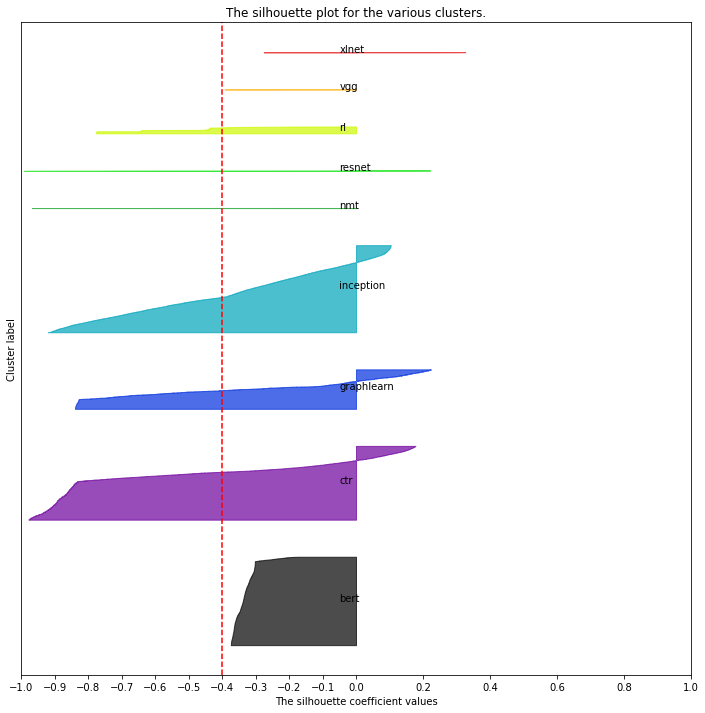

In [113]:
plot_silhouette_results(y, sample_silhouette_values_6.mean(), sample_silhouette_values_6, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### write

In [114]:
sample_silhouette_values_7 = silhouette_samples(selected_usage_normalized[:,7:8], y)

In [115]:
sample_silhouette_values_7.mean()

-0.3237506489707614

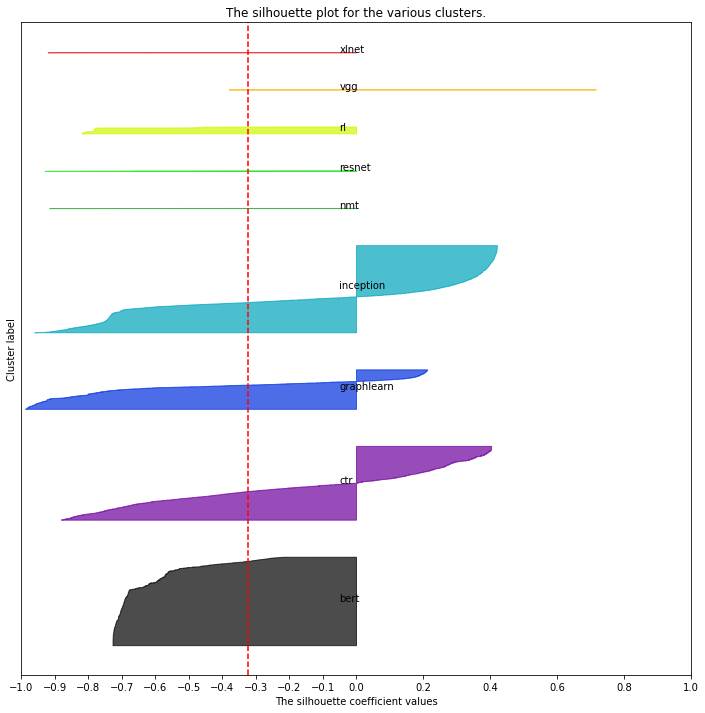

In [116]:
plot_silhouette_results(y, sample_silhouette_values_7.mean(), sample_silhouette_values_7, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### read_count

#### Using **euclidean distance**

In [117]:
sample_silhouette_values_8 = silhouette_samples(selected_usage_normalized[:,8:9], y)

In [118]:
sample_silhouette_values_8.mean()

-0.2789118409288163

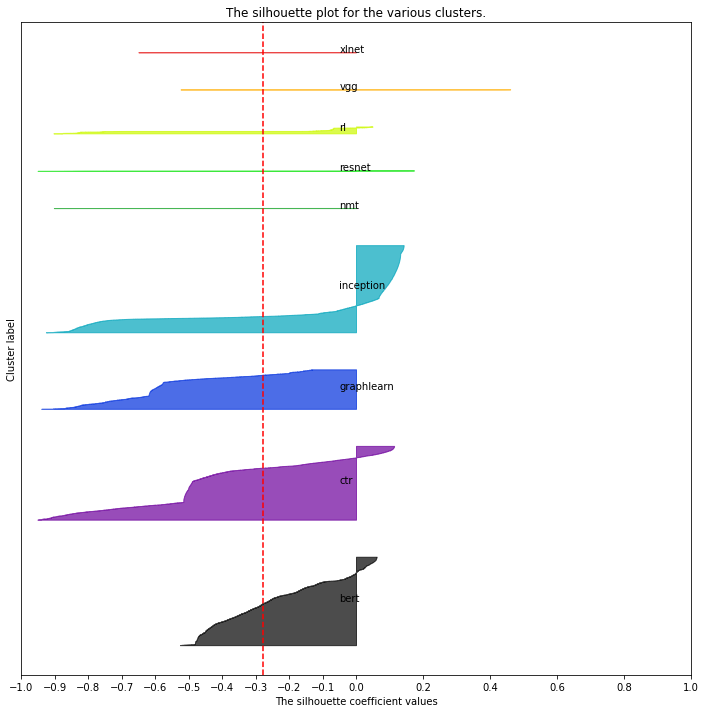

In [119]:
plot_silhouette_results(y, sample_silhouette_values_8.mean(), sample_silhouette_values_8, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

### write_count

#### Using **euclidean distance**

In [120]:
sample_silhouette_values_9 = silhouette_samples(selected_usage_normalized[:,9:], y)

In [121]:
sample_silhouette_values_9.mean()

-0.12431468569885758

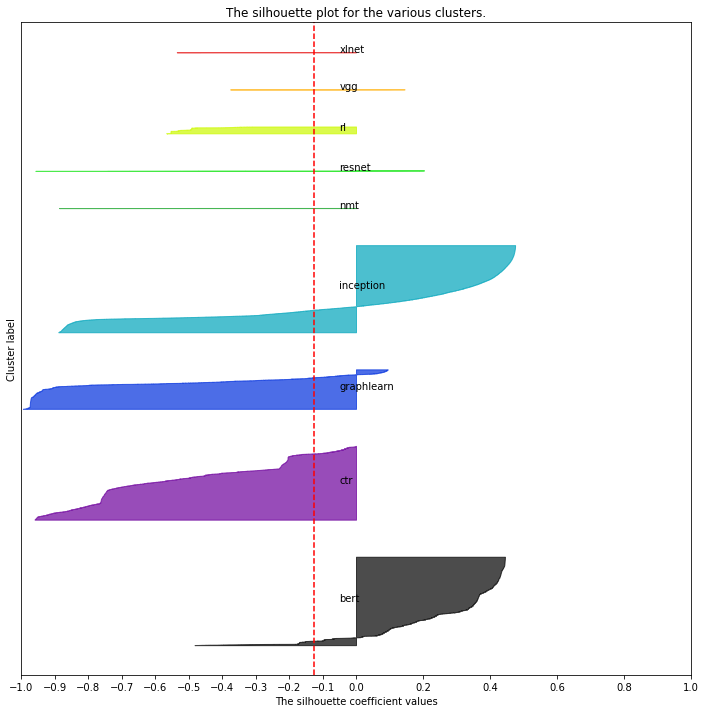

In [122]:
plot_silhouette_results(y, sample_silhouette_values_9.mean(), sample_silhouette_values_9, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

## Analyze the *Task_name* feature

In [534]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(examples_sampled['task_name'])
y_task_name = le.transform(examples_sampled['task_name'])

In [535]:
le_name_mapping_task_name = dict(zip(le.transform(le.classes_), le.classes_))

In [536]:
le_name_mapping_task_name

{0: 'OpenmpiTracker',
 1: 'OssToVolumeWorker',
 2: 'PyTorchWorker',
 3: 'evaluator',
 4: 'ps',
 5: 'tensorflow',
 6: 'worker'}

### Overall results (using all features)

#### Using **euclidean distance**

In [537]:
sample_silhouette_values_task_name = silhouette_samples(selected_usage_normalized, y_task_name, metric='euclidean')

In [538]:
sample_silhouette_values_task_name.mean()

-0.07268013143445345

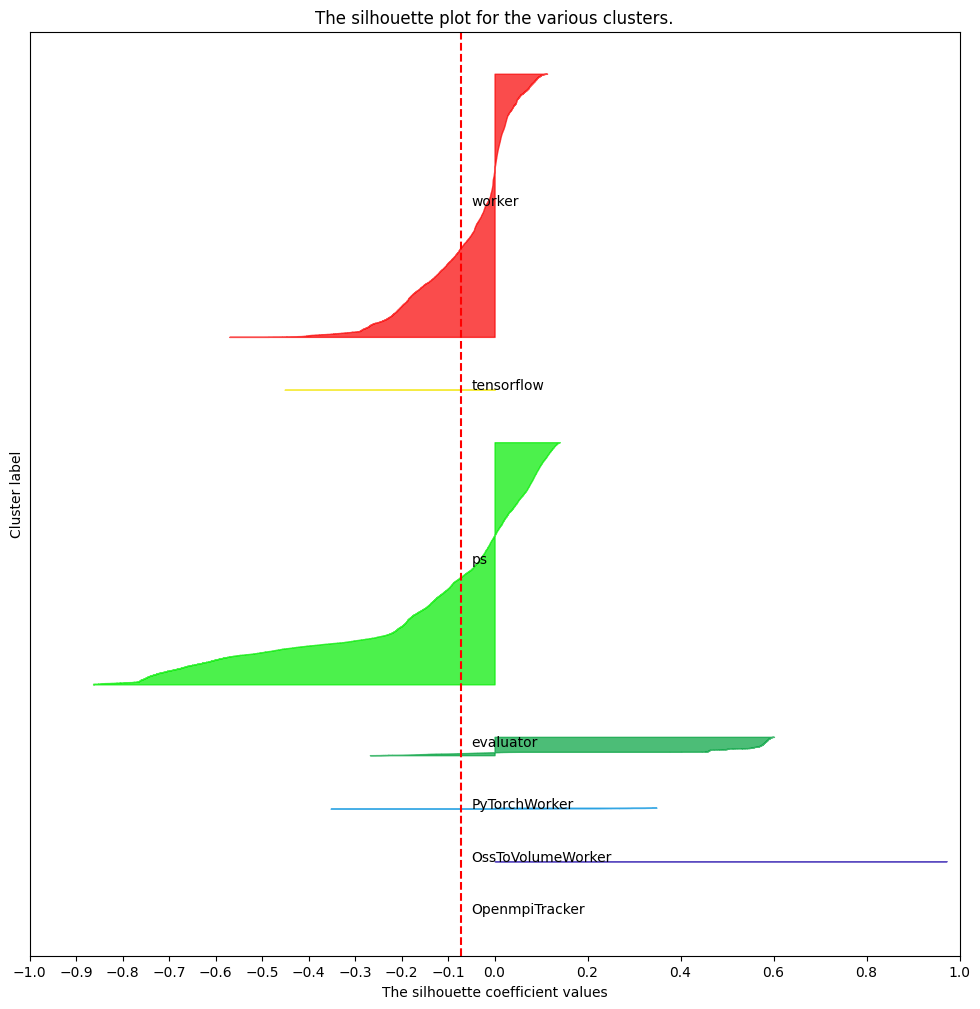

In [539]:
plot_silhouette_results(y_task_name, sample_silhouette_values_task_name.mean(), sample_silhouette_values_task_name, len(set(y_task_name)), multiplier=10000, le_name_mapping=le_name_mapping_task_name)

#### Using **cosine distance**

In [540]:
sample_silhouette_values_task_name_cosine= silhouette_samples(selected_usage_normalized, y_task_name, metric='cosine')

In [541]:
sample_silhouette_values_task_name_cosine.mean()

-0.19237409761674268

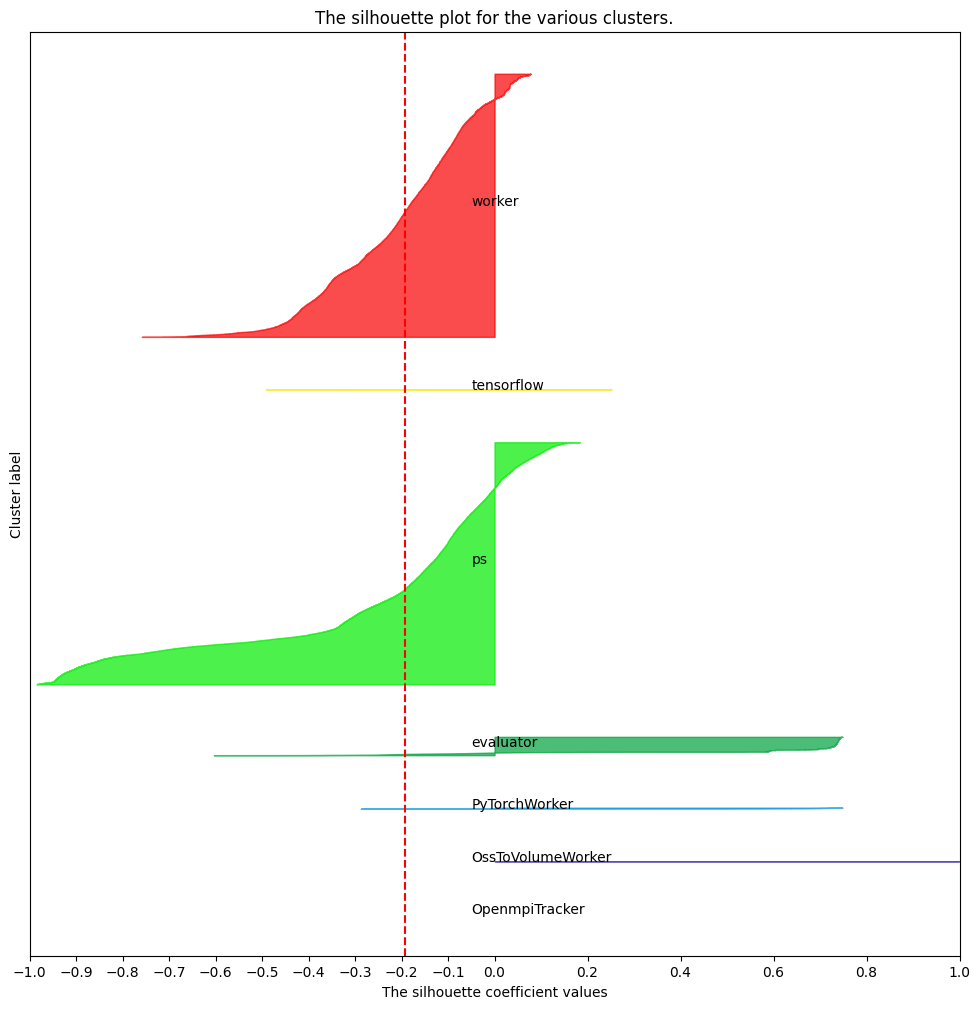

In [542]:
plot_silhouette_results(y_task_name, sample_silhouette_values_task_name_cosine.mean(), sample_silhouette_values_task_name_cosine, len(set(y_task_name)), multiplier=10000, le_name_mapping=le_name_mapping_task_name)

#### Using **manhattan distance**

https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6

In [543]:
sample_silhouette_values_task_name_manhattan = silhouette_samples(selected_usage_normalized, y_task_name, metric='manhattan')

In [544]:
sample_silhouette_values_task_name_manhattan.mean()

-0.10112654935357183

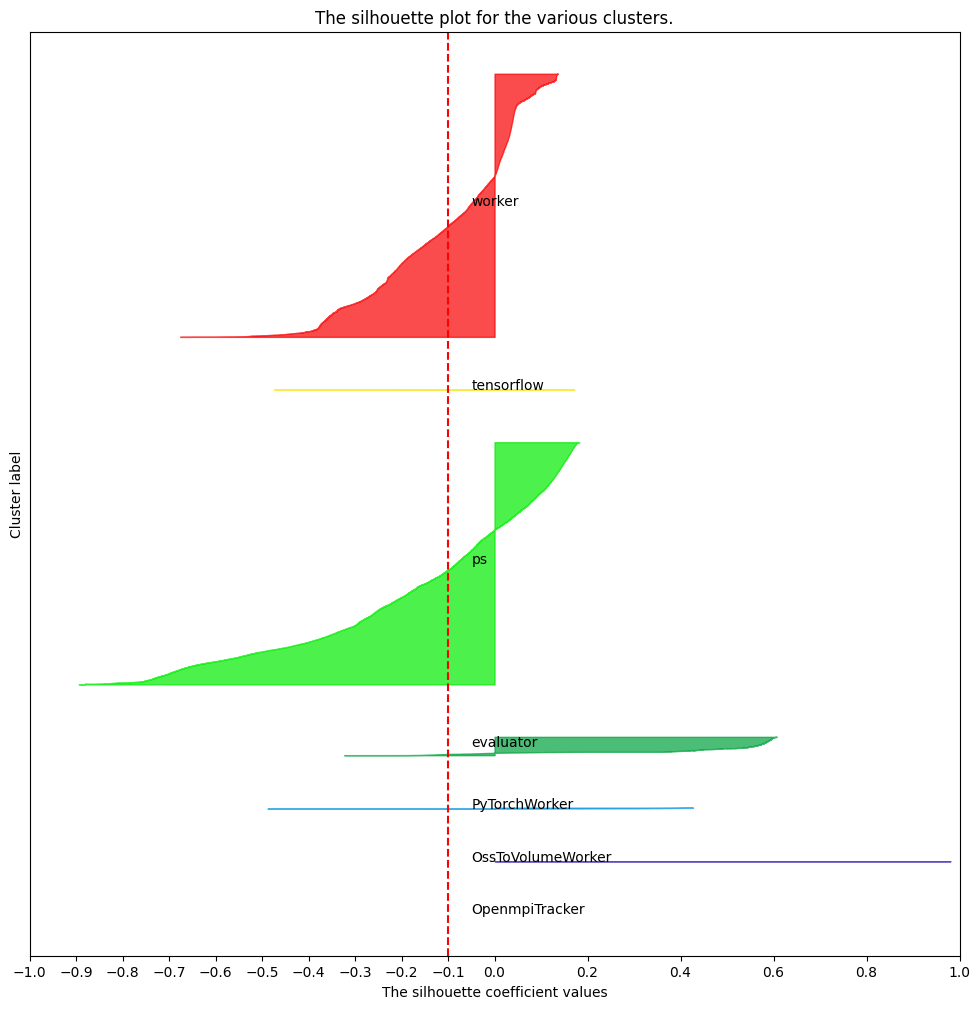

In [545]:
plot_silhouette_results(y_task_name, sample_silhouette_values_task_name_manhattan.mean(), sample_silhouette_values_task_name_manhattan, len(set(y_task_name)), multiplier=10000, le_name_mapping=le_name_mapping_task_name)

## Analyze the *User* feature

In [546]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(examples_sampled['user'])
y_user = le.transform(examples_sampled['user'])

In [547]:
le_name_mapping_user = dict(zip(le.transform(le.classes_), le.classes_))

### Overall results (using all features)

In [548]:
sample_silhouette_values_user = silhouette_samples(selected_usage_normalized, y_user)

In [549]:
sample_silhouette_values_user.mean()

-0.17708023673070133

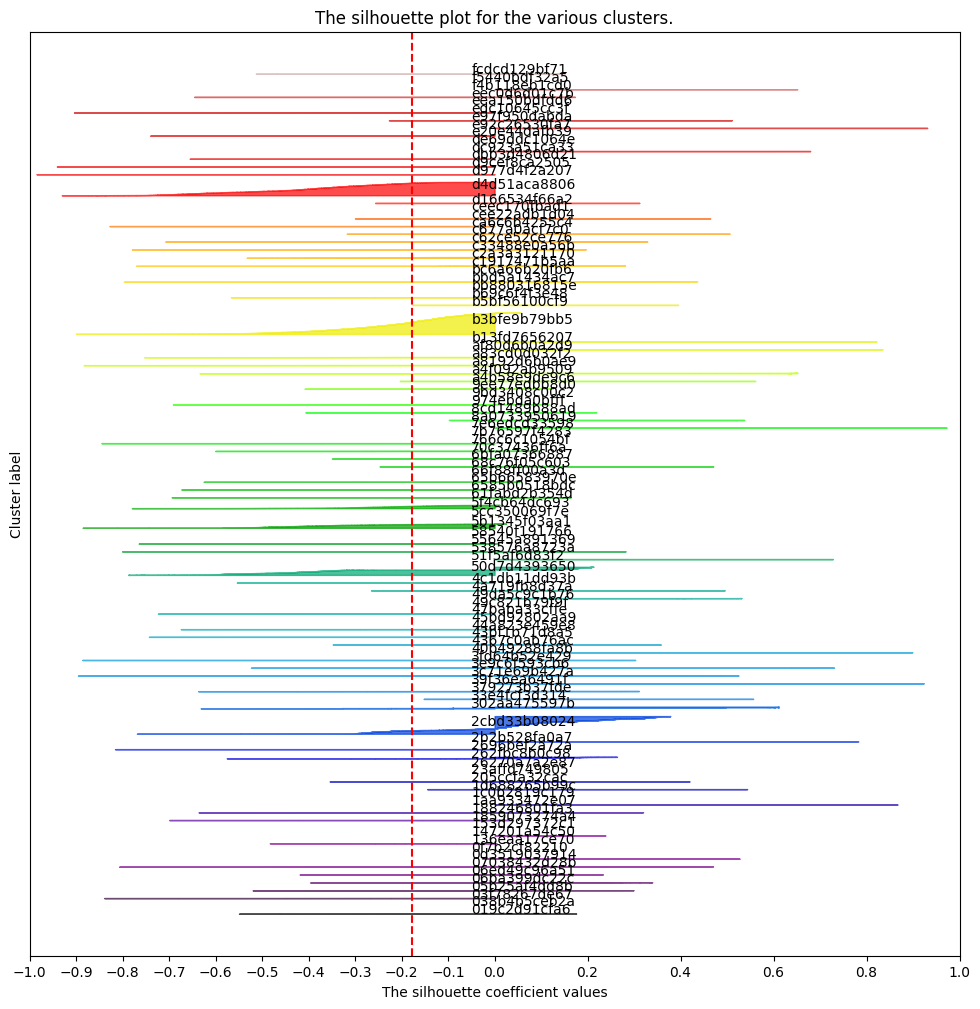

In [550]:
plot_silhouette_results(y_user, sample_silhouette_values_user.mean(), sample_silhouette_values_user, len(set(y_user)), multiplier=10000, le_name_mapping=le_name_mapping_user)

## Analyze the *Group* feature

In [551]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(examples_sampled['group'])
y_group = le.transform(examples_sampled['group'])

In [552]:
le_name_mapping_group = dict(zip(le.transform(le.classes_), le.classes_))

### Overall results (using all features)

In [553]:
sample_silhouette_values_group = silhouette_samples(selected_usage_normalized, y_group)

In [554]:
sample_silhouette_values_group.mean()

-0.30086013325126815

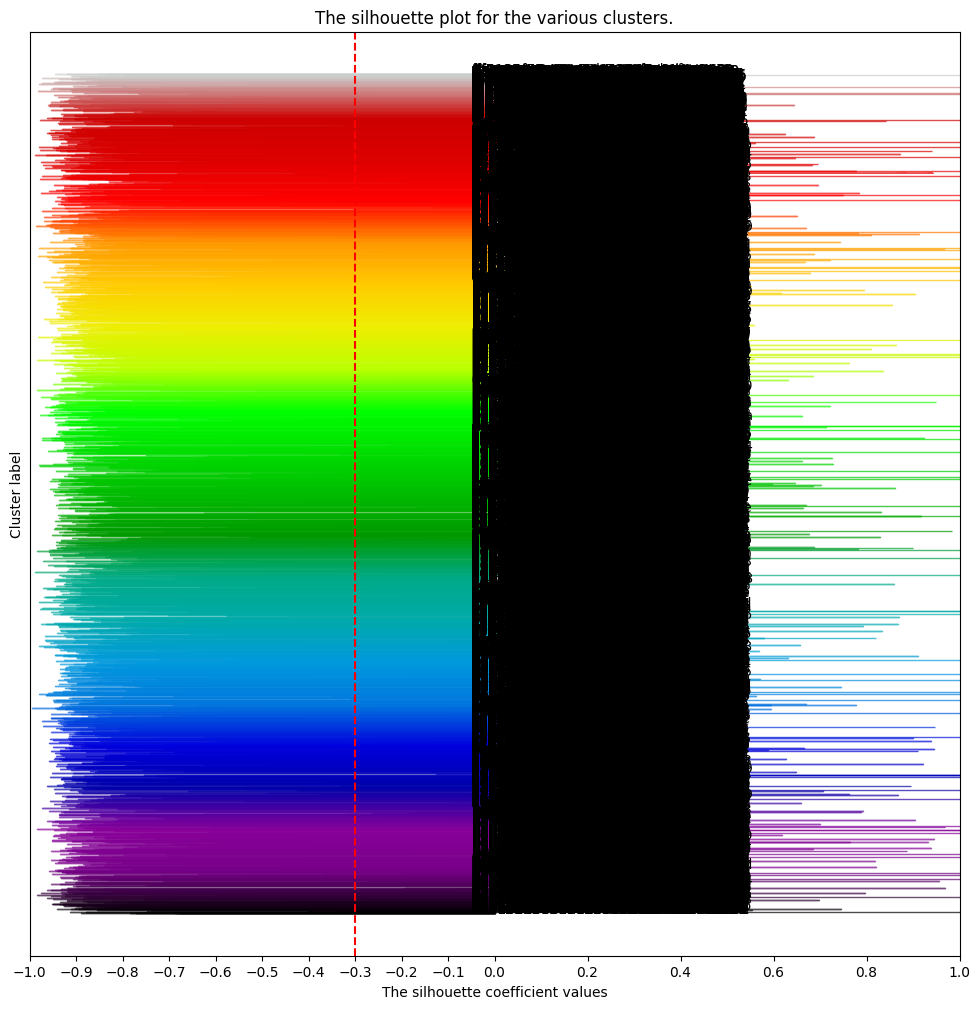

In [555]:
plot_silhouette_results(y_group, sample_silhouette_values_group.mean(), sample_silhouette_values_group, len(set(y_group)), multiplier=10000, le_name_mapping=le_name_mapping_group)

## Combine features

### Workload + task name

In [556]:
workload_task_name = [x[0]+'_'+x[1] for x in list(zip(examples_sampled.workload, examples_sampled.task_name))]

In [557]:
le = LabelEncoder()
le.fit(workload_task_name)
y_workload_task_name = le.transform(workload_task_name)

In [558]:
le_name_mapping_workload_task_name = dict(zip(le.transform(le.classes_), le.classes_))

In [559]:
le_name_mapping_workload_task_name

{0: 'bert_OssToVolumeWorker',
 1: 'bert_PyTorchWorker',
 2: 'bert_evaluator',
 3: 'bert_ps',
 4: 'bert_tensorflow',
 5: 'bert_worker',
 6: 'ctr_evaluator',
 7: 'ctr_ps',
 8: 'ctr_tensorflow',
 9: 'ctr_worker',
 10: 'graphlearn_ps',
 11: 'graphlearn_tensorflow',
 12: 'graphlearn_worker',
 13: 'inception_ps',
 14: 'inception_worker',
 15: 'nmt_PyTorchWorker',
 16: 'nmt_worker',
 17: 'resnet_ps',
 18: 'resnet_worker',
 19: 'rl_PyTorchWorker',
 20: 'rl_worker',
 21: 'vgg_OpenmpiTracker',
 22: 'vgg_ps',
 23: 'vgg_worker',
 24: 'xlnet_ps',
 25: 'xlnet_worker'}

#### Using **euclidean distance**

In [560]:
sample_silhouette_workload_task_name_values = silhouette_samples(selected_usage_normalized, y_workload_task_name)

In [561]:
sample_silhouette_workload_task_name_values.mean()

0.01842469624106385

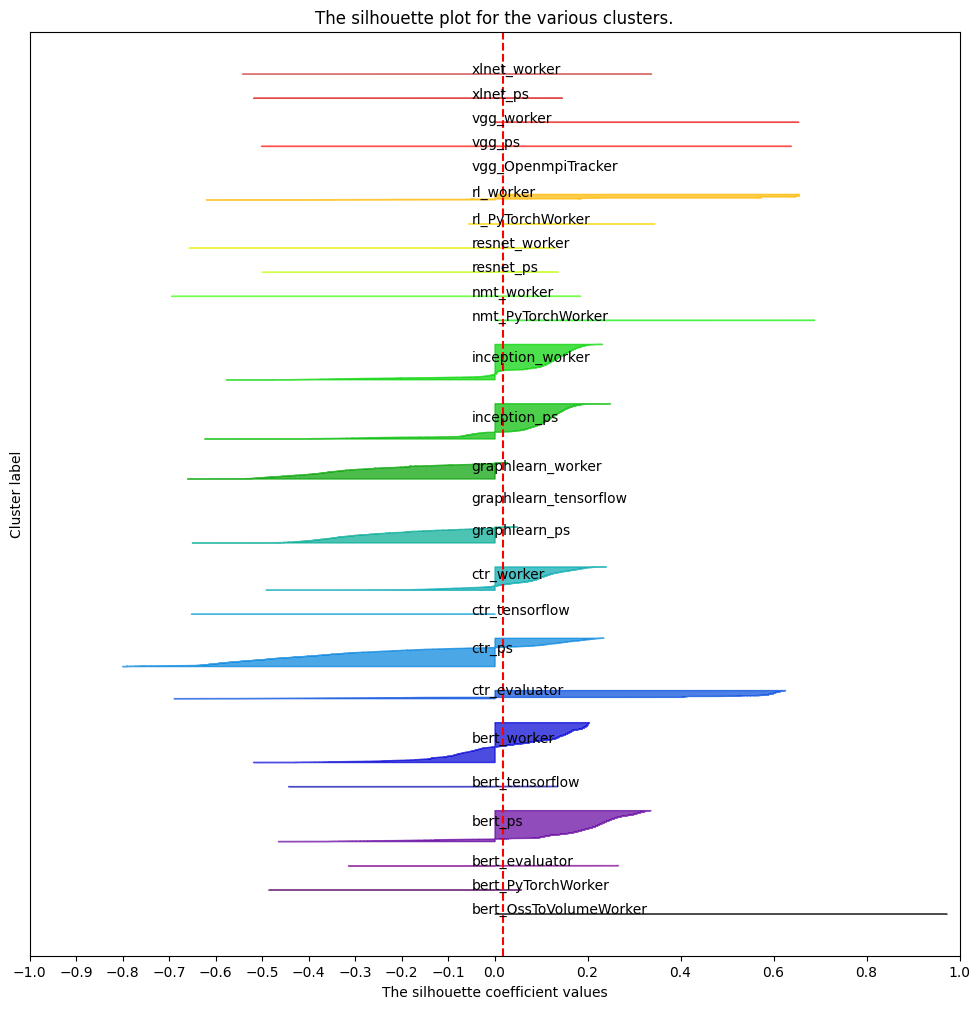

In [562]:
plot_silhouette_results(y_workload_task_name, sample_silhouette_workload_task_name_values.mean(), sample_silhouette_workload_task_name_values, len(set(y_workload_task_name)), multiplier=10000, le_name_mapping=le_name_mapping_workload_task_name)

#### Using **cosine distance**

In [563]:
sample_silhouette_workload_task_name_values_cosine = silhouette_samples(selected_usage_normalized, y_workload_task_name, metric='cosine')

In [564]:
sample_silhouette_workload_task_name_values_cosine.mean()

-0.008996449133780308

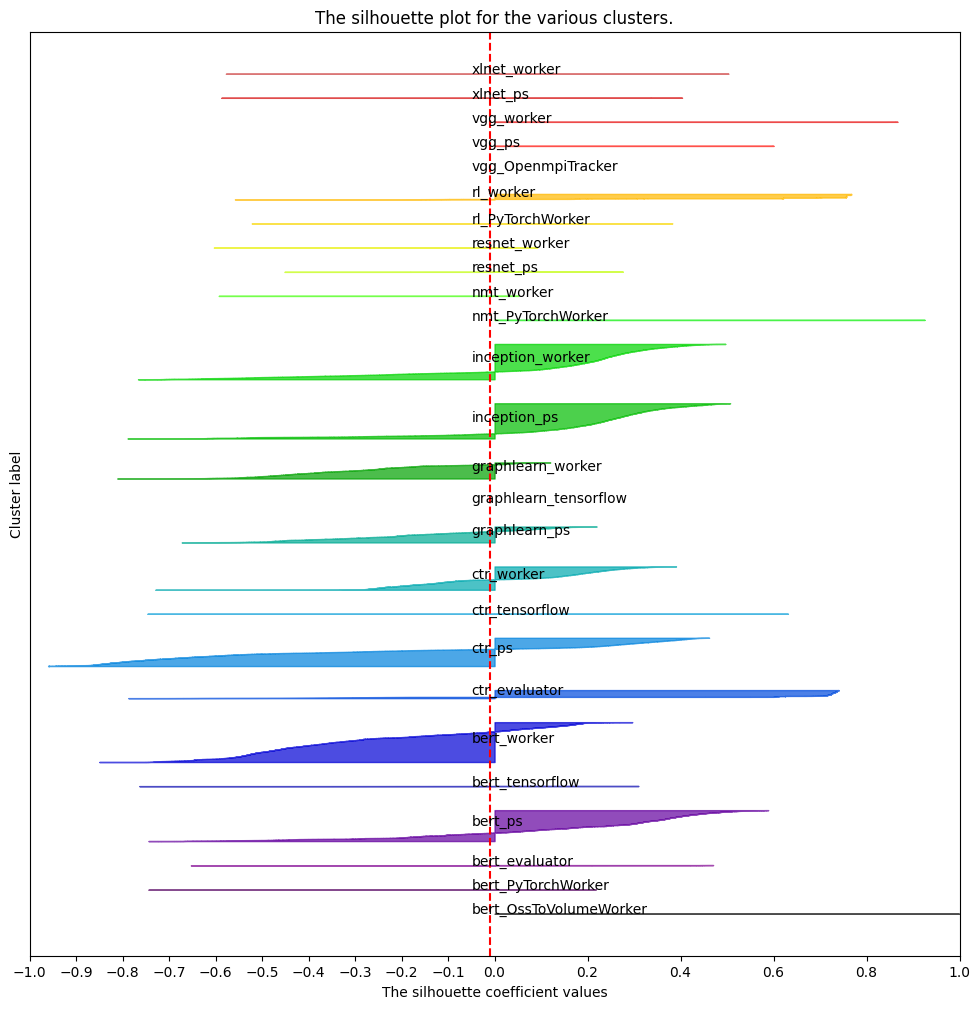

In [565]:
plot_silhouette_results(y_workload_task_name, sample_silhouette_workload_task_name_values_cosine.mean(), sample_silhouette_workload_task_name_values_cosine, len(set(y_workload_task_name)), multiplier=10000, le_name_mapping=le_name_mapping_workload_task_name)

#### Using **manhattan distance**

https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6

In [566]:
sample_silhouette_workload_task_name_values_manhattan = silhouette_samples(selected_usage_normalized, y_workload_task_name, metric='manhattan')

In [567]:
sample_silhouette_workload_task_name_values_manhattan.mean()

0.07968881198594417

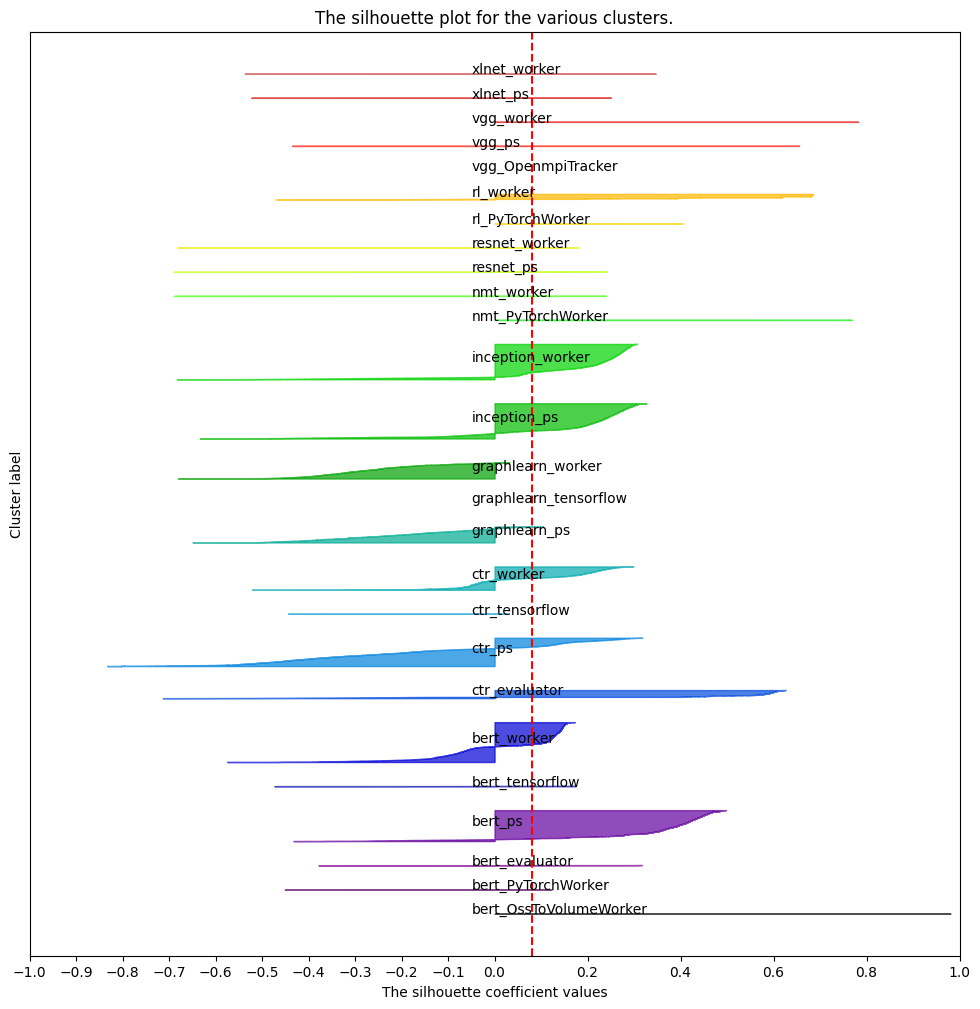

In [568]:
plot_silhouette_results(y_workload_task_name, sample_silhouette_workload_task_name_values_manhattan.mean(), sample_silhouette_workload_task_name_values_manhattan, len(set(y_workload_task_name)), multiplier=10000, le_name_mapping=le_name_mapping_workload_task_name)

### Workload + task name + group

In [569]:
workload_task_name_group = [x[0]+'_'+x[1]+'_'+x[2] for x in list(zip(examples_sampled.workload, examples_sampled.task_name, examples_sampled.group))]

In [570]:
le = LabelEncoder()
le.fit(workload_task_name_group)
y_workload_task_name_group = le.transform(workload_task_name_group)

In [571]:
le_name_mapping_workload_task_name_group = dict(zip(le.transform(le.classes_), le.classes_))

In [572]:
len(le_name_mapping_workload_task_name_group)

8027

#### Using **euclidean distance**

In [573]:
sample_silhouette_workload_task_name_group_values = silhouette_samples(selected_usage_normalized, y_workload_task_name_group)

In [574]:
sample_silhouette_workload_task_name_group_values.mean()

-0.17706318207537466

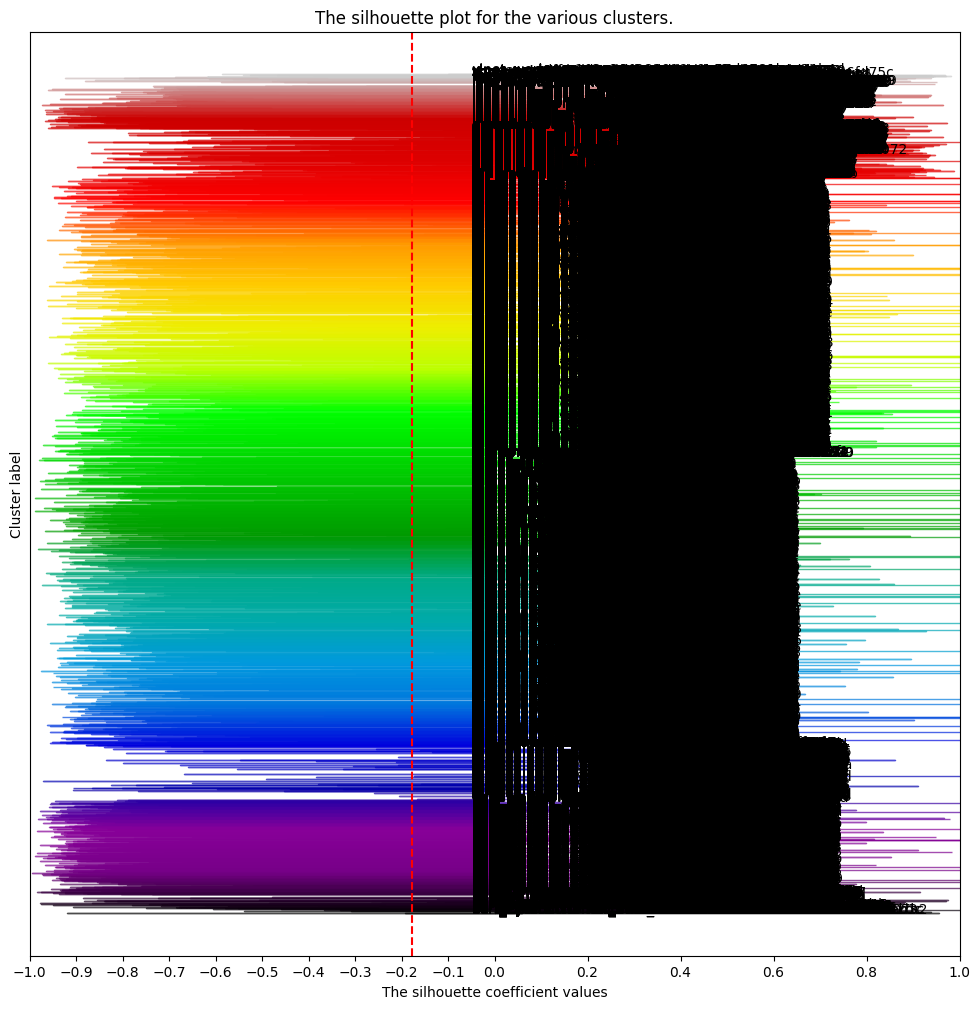

In [575]:
plot_silhouette_results(y_workload_task_name_group, sample_silhouette_workload_task_name_group_values.mean(), sample_silhouette_workload_task_name_group_values, len(set(y_workload_task_name_group)), multiplier=10000, le_name_mapping=le_name_mapping_workload_task_name_group)

#### Using **cosine distance**

In [576]:
sample_silhouette_workload_task_name_group_values_cosine = silhouette_samples(selected_usage_normalized, y_workload_task_name_group, metric='cosine')

In [577]:
sample_silhouette_workload_task_name_group_values_cosine.mean()

-0.3758986391507332

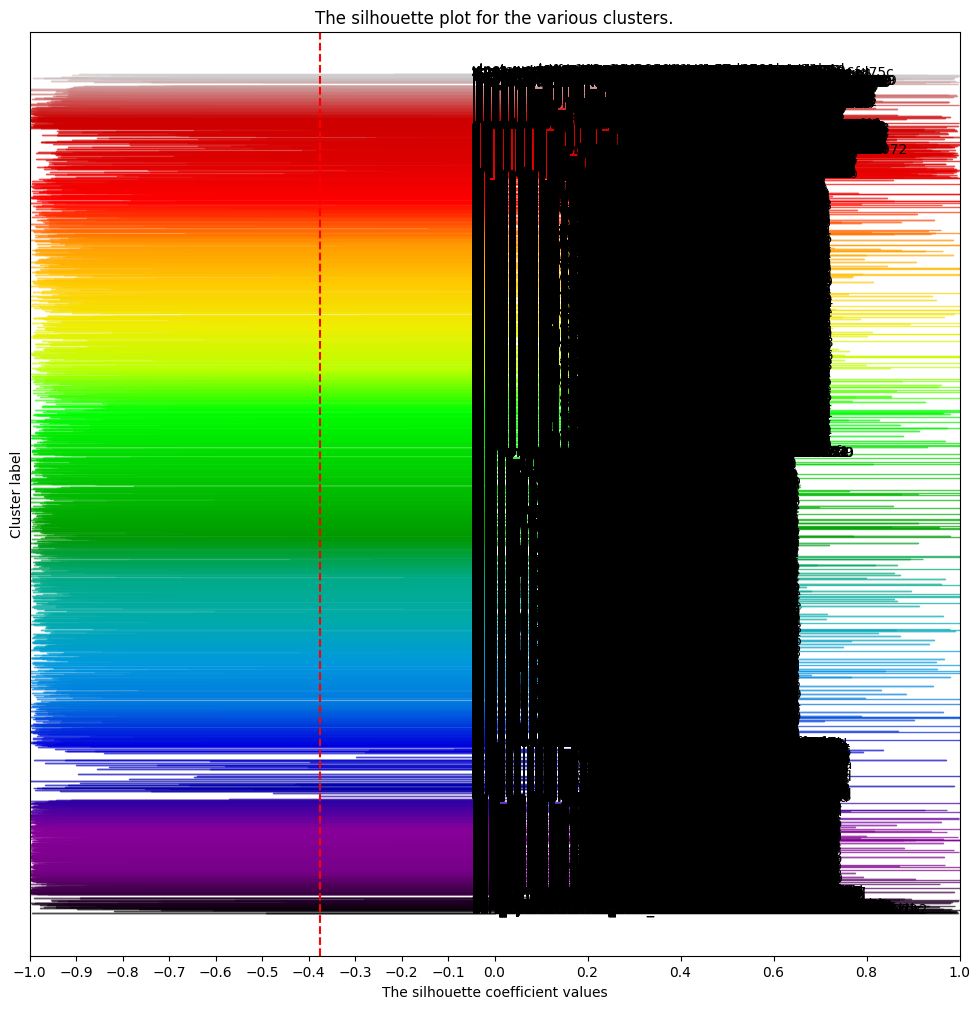

In [578]:
plot_silhouette_results(y_workload_task_name_group, sample_silhouette_workload_task_name_group_values_cosine.mean(), sample_silhouette_workload_task_name_group_values_cosine, len(set(y_workload_task_name_group)), multiplier=10000, le_name_mapping=le_name_mapping_workload_task_name_group)

#### Using **manhattan distance**

https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6

In [579]:
sample_silhouette_workload_task_name_group_values_manhattan = silhouette_samples(selected_usage_normalized, y_workload_task_name_group, metric='manhattan')

In [580]:
sample_silhouette_workload_task_name_group_values_manhattan.mean()

-0.10038893813309821

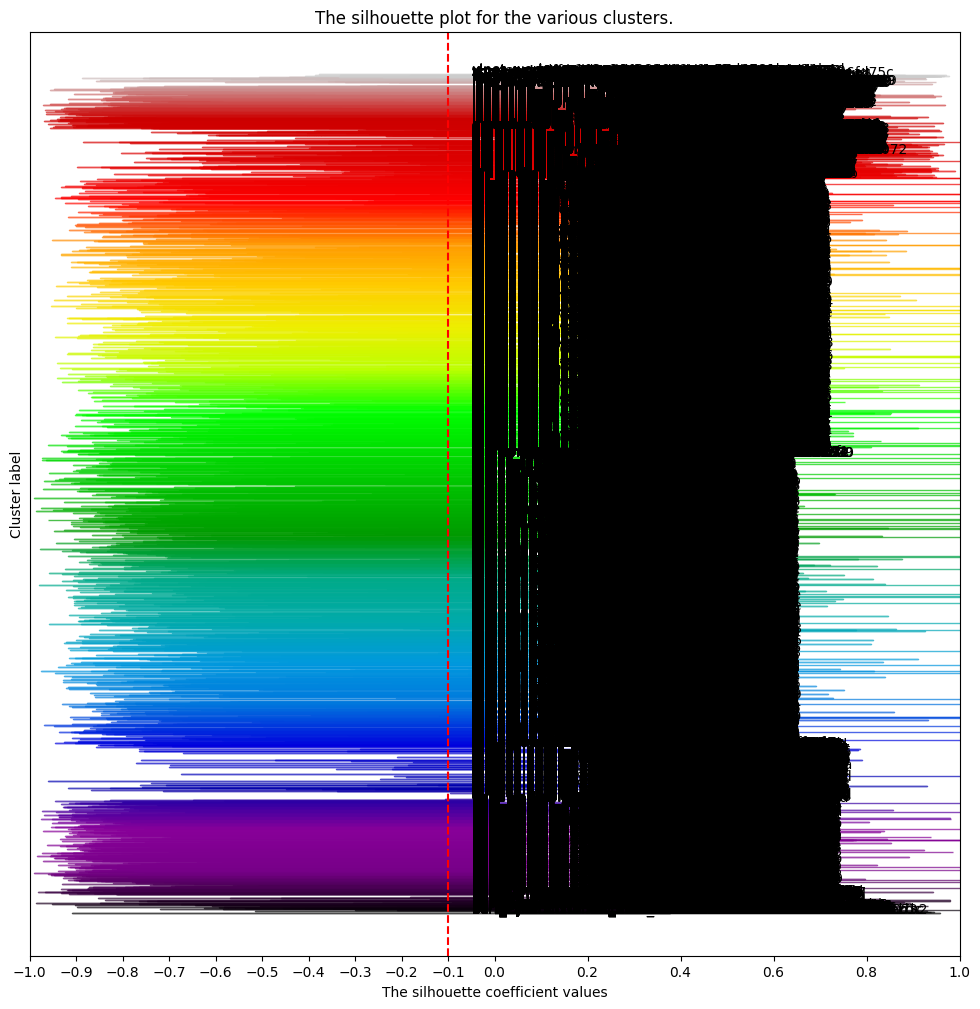

In [581]:
plot_silhouette_results(y_workload_task_name_group, sample_silhouette_workload_task_name_group_values_manhattan.mean(), sample_silhouette_workload_task_name_group_values_manhattan, len(set(y_workload_task_name_group)), multiplier=10000, le_name_mapping=le_name_mapping_workload_task_name_group)

## Try **PCA** Dimensionality reduction

https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d

In [582]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.85)

In [583]:
pca.fit(selected_usage_normalized)

PCA(n_components=0.85)

In [584]:
pca.n_components_

9

In [585]:
res_pca = pca.transform(selected_usage_normalized)

### _Workload_ feature results

#### Using **euclidean distance**

In [586]:
sample_silhouette_values_pca = silhouette_samples(res_pca, y)

In [587]:
sample_silhouette_values_pca.mean()

0.1715736102886747

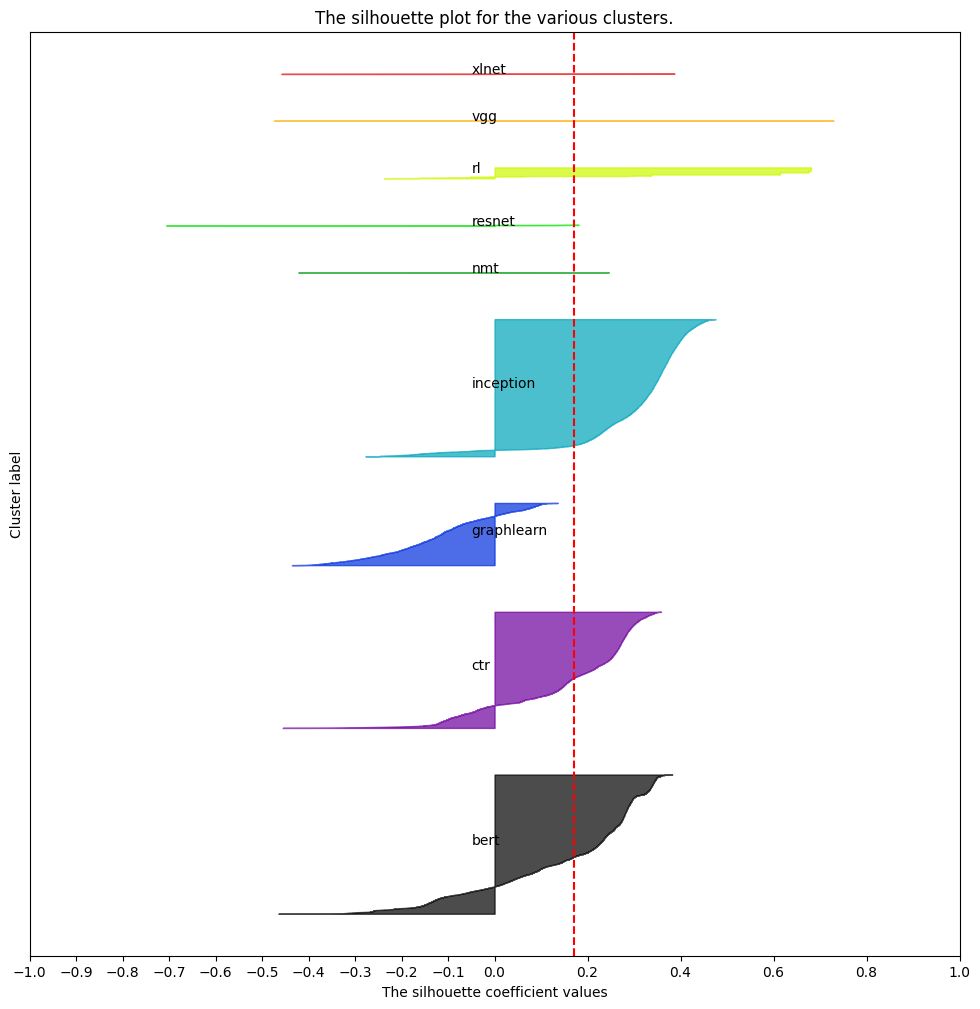

In [588]:
plot_silhouette_results(y, sample_silhouette_values_pca.mean(), sample_silhouette_values_pca, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

#### Using **cosine distance**

In [589]:
sample_silhouette_values_cosine_pca = silhouette_samples(res_pca, y, metric='cosine')

In [590]:
sample_silhouette_values_cosine_pca.mean()

0.021004819290722194

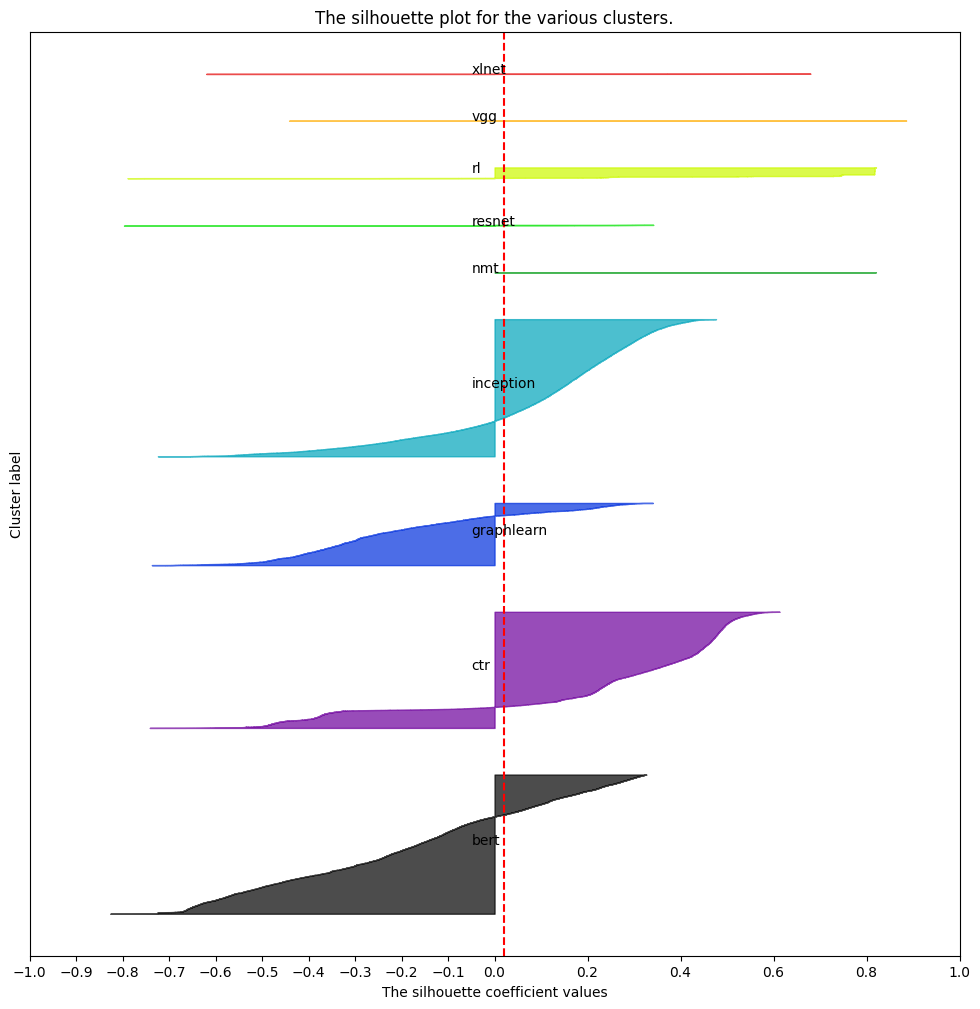

In [591]:
plot_silhouette_results(y, sample_silhouette_values_cosine_pca.mean(), sample_silhouette_values_cosine_pca, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

#### Using **manhattan distance**

https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6

In [592]:
sample_silhouette_values_manhattan_pca = silhouette_samples(res_pca, y, metric='manhattan')

In [593]:
sample_silhouette_values_manhattan_pca.mean()

0.15537786251310481

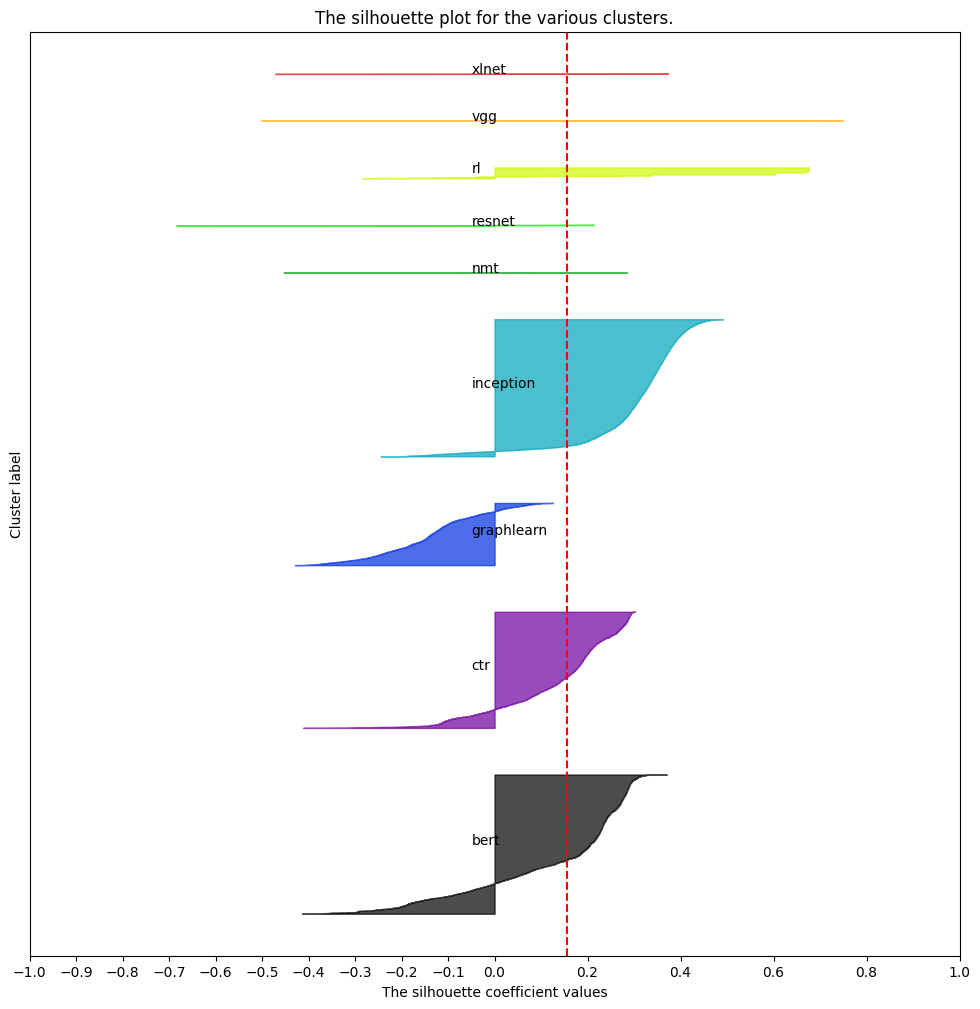

In [594]:
plot_silhouette_results(y, sample_silhouette_values_manhattan_pca.mean(), sample_silhouette_values_manhattan_pca, len(set(y)), multiplier=10000, le_name_mapping=le_name_mapping)

## Let's try with Classification

### _XGBoost_ on _workload_

In [595]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

In [596]:
X_train, X_test, y_train, y_test = train_test_split(selected_usage_normalized, y, test_size=0.20, random_state=5)

In [597]:
(X_train.shape, X_test.shape)

((80000, 17), (20001, 17))

In [598]:
model = XGBClassifier() 

model.fit(X_train, y_train)

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [599]:
y_pred = model.predict(X_test) 

predictions = [round(value) for value in y_pred]

In [600]:
accuracy = accuracy_score(y_test, predictions) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.95%


In [601]:
y_test[:20]

array([1, 2, 0, 2, 0, 3, 3, 0, 1, 0, 3, 0, 1, 3, 1, 0, 0, 1, 1, 3])

In [602]:
np.array(predictions[:20])

array([1, 2, 0, 2, 0, 3, 3, 0, 1, 0, 3, 0, 1, 3, 1, 0, 0, 1, 1, 3])

In [603]:
from xgboost import plot_tree

In [607]:
model.get_booster().feature_names = list(selected_df.select_dtypes(include=[np.number]).columns.values)#['cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count', 'write_count', 'runtime']

In [608]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

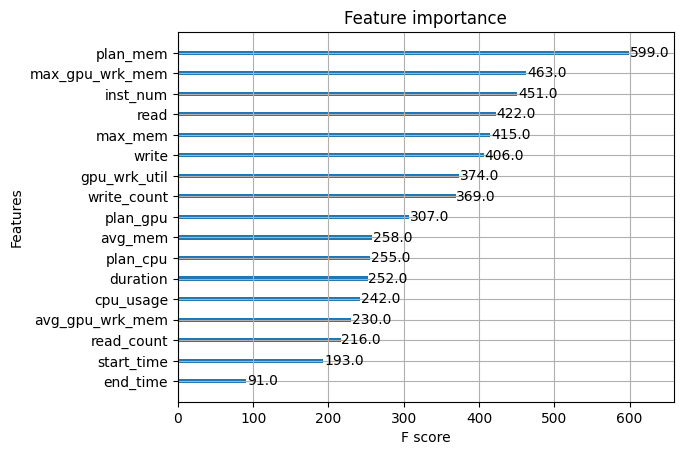

In [609]:
from xgboost import plot_importance

plot_importance(model)

In [610]:
from xgboost import to_graphviz

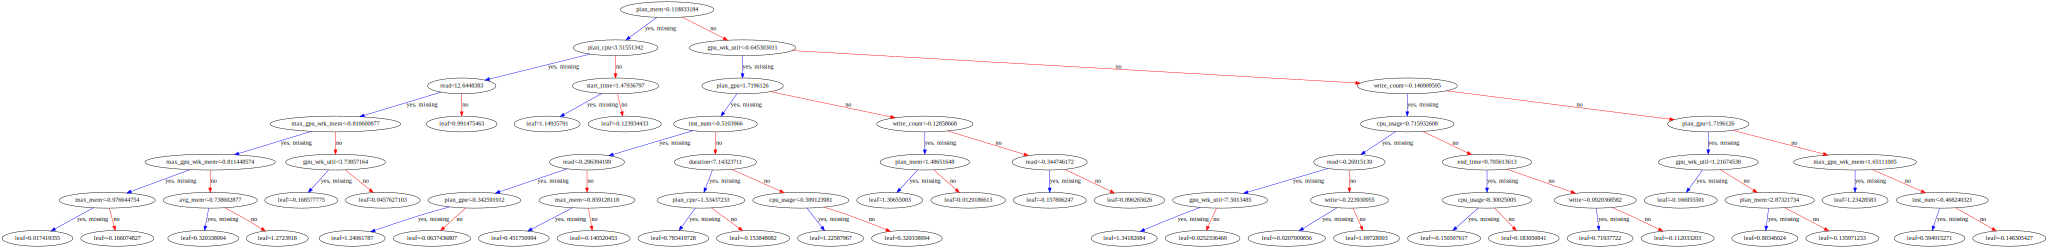

In [611]:
to_graphviz(model)

In [612]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5969
           1       1.00      1.00      1.00      5069
           2       1.00      1.00      1.00      2672
           3       1.00      1.00      1.00      5799
           4       1.00      0.75      0.86         8
           5       1.00      1.00      1.00        28
           6       1.00      1.00      1.00       443
           7       1.00      1.00      1.00         5
           8       1.00      0.75      0.86         8

    accuracy                           1.00     20001
   macro avg       1.00      0.94      0.97     20001
weighted avg       1.00      1.00      1.00     20001



### _XGBoost_ on _workload + task name_

In [613]:
X_train_wtn, X_test_wtn, y_train_wtn, y_test_wtn = train_test_split(selected_usage_normalized, y_workload_task_name, test_size=0.20, random_state=5)

In [614]:
(X_train_wtn.shape, X_test_wtn.shape)

((80000, 17), (20001, 17))

In [615]:
model_wtn = XGBClassifier() 

model_wtn.fit(X_train_wtn, y_train_wtn)

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [616]:
y_pred_wtn = model_wtn.predict(X_test_wtn) 

predictions_wtn = [round(value) for value in y_pred_wtn]

In [617]:
accuracy_wtn = accuracy_score(y_test_wtn, predictions_wtn) 

print("Accuracy: %.2f%%" % (accuracy_wtn * 100.0))

Accuracy: 99.89%


In [618]:
y_test_wtn[:20]

array([ 9, 12,  3, 10,  5, 13, 13,  5,  9,  3, 14,  5,  7, 14,  9,  3,  5,
        7,  6, 14])

In [619]:
np.array(predictions_wtn[:20])

array([ 9, 12,  3, 10,  5, 13, 13,  5,  9,  3, 14,  5,  7, 14,  9,  3,  5,
        7,  6, 14])

In [620]:
model_wtn.get_booster().feature_names = list(selected_df.select_dtypes(include=[np.number]).columns.values) #['cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count', 'write_count', 'runtime']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

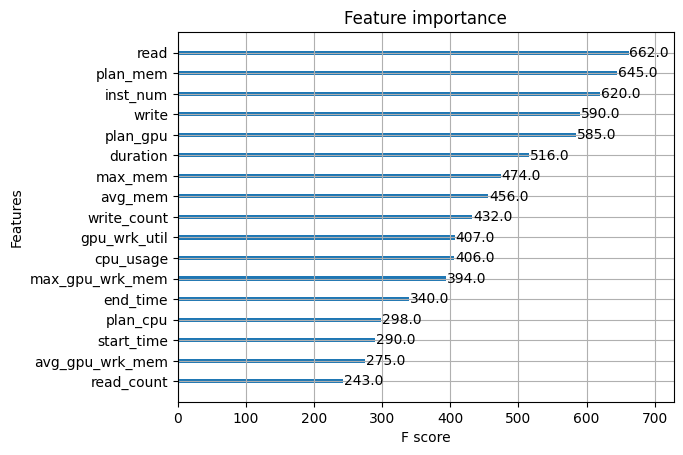

In [621]:
from xgboost import plot_importance

plot_importance(model_wtn)

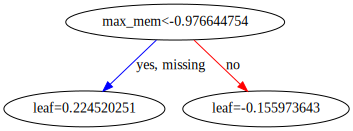

In [622]:
to_graphviz(model_wtn)

In [623]:
from sklearn.metrics import classification_report,confusion_matrix

In [624]:
print(classification_report(y_test_wtn, predictions_wtn))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00        28
           2       0.88      0.81      0.85        27
           3       1.00      1.00      1.00      2531
           4       1.00      0.87      0.93        15
           5       1.00      1.00      1.00      3367
           6       1.00      1.00      1.00       684
           7       1.00      1.00      1.00      2420
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00      1964
          10       1.00      1.00      1.00      1373
          12       1.00      1.00      1.00      1299
          13       1.00      1.00      1.00      2881
          14       1.00      1.00      1.00      2918
          15       1.00      1.00      1.00         4
          16       1.00      0.50      0.67         4
          17       1.00      1.00      1.00        20
          18       1.00    

## Try to cluster with OPTICS

In [663]:
from sklearn.cluster import OPTICS

In [667]:
clusterer_OPTICS = OPTICS(min_samples=400, metric='manhattan') #, n_jobs=-1)

In [668]:
clusterer_OPTICS.fit_predict(selected_usage_normalized)

array([ 0,  0, -1, ..., -1, -1, -1])

### Analyze results

<AxesSubplot:ylabel='count'>

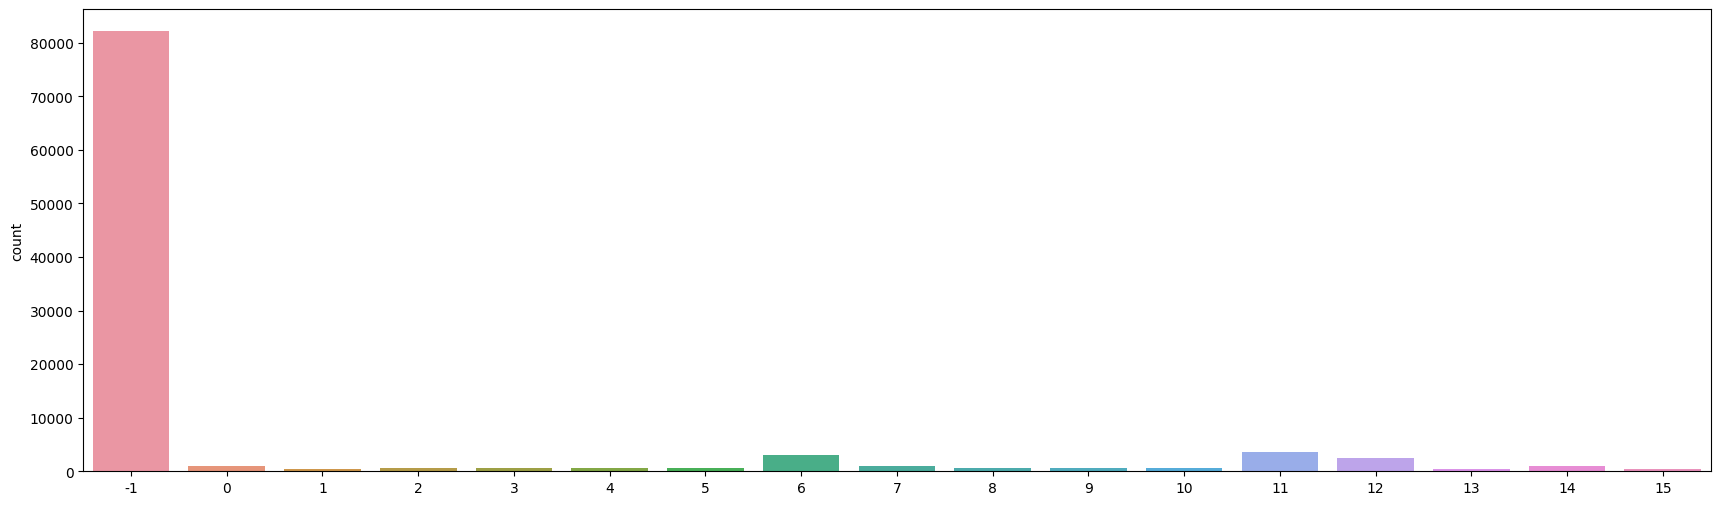

In [688]:
plt.figure(figsize=(21,6))
sns.countplot(x=clusterer_OPTICS.labels_)

### Compute Silhouette

In [669]:
silhouette_OPTICS_400_manhattan = silhouette_samples(selected_usage_normalized, clusterer_OPTICS.labels_, metric='manhattan')

In [670]:
mask_OPTICS_400 = np.array([1 if x>-1 else 0 for x in clusterer_OPTICS.labels_])
mask_OPTICS_400

array([1, 1, 0, ..., 0, 0, 0])

In [671]:
silhouette_masked_OPTICS = silhouette_OPTICS_400_manhattan[mask_OPTICS_400.astype(bool)]

In [672]:
silhouette_masked_OPTICS.mean()

0.676684509392559

In [673]:
silhouette_OPTICS_400_manhattan

array([ 0.77645022,  0.72232452, -0.40729701, ..., -0.70196531,
       -0.638453  , -0.79282117])

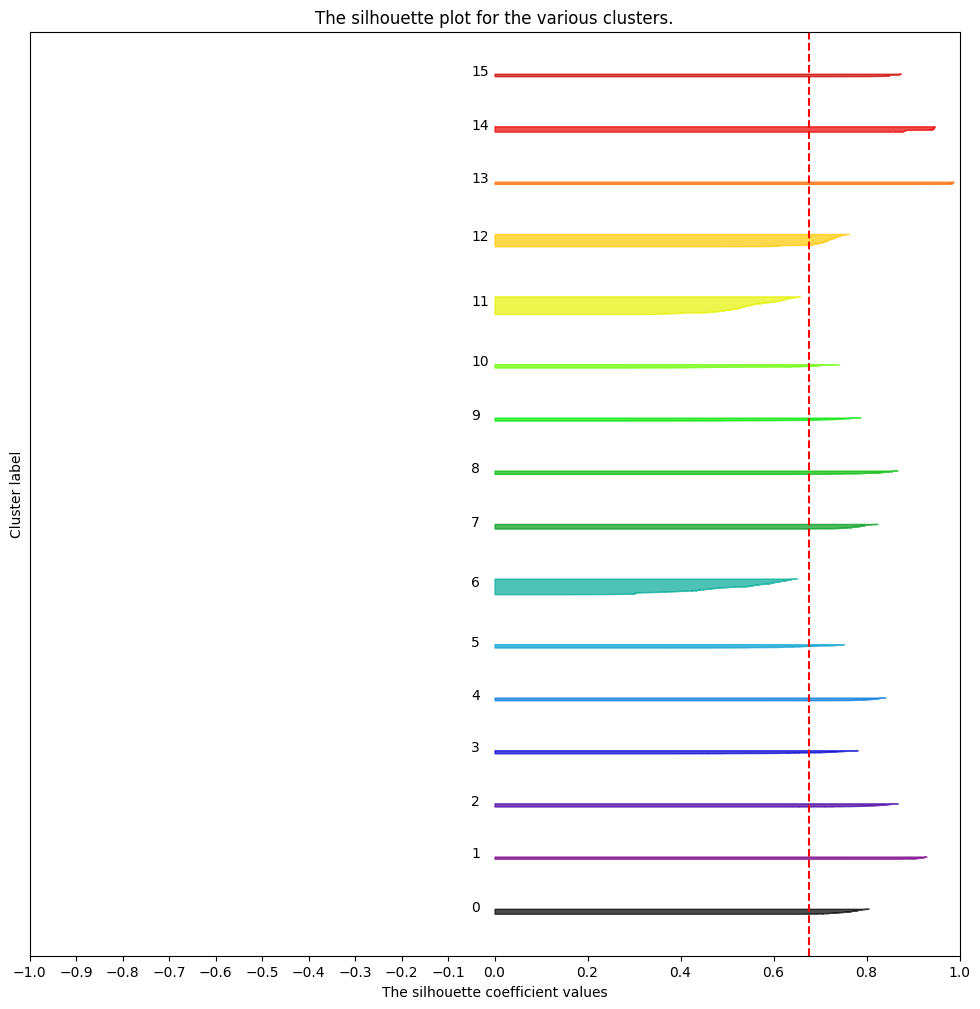

In [674]:
plot_silhouette_results(clusterer_OPTICS.labels_, silhouette_masked_OPTICS.mean(), silhouette_OPTICS_400_manhattan, max(clusterer_OPTICS.labels_) + 1, multiplier=10000)

In [693]:
np.max(clusterer_OPTICS.labels_)+1

15

### PCA Visualization

In [677]:

cluster_colors_OPTICS = [sns.desaturate(palette[col], 1) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col in 
                  clusterer_OPTICS.labels_]

#### Plot 2D

In [678]:
pca_vis = PCA(n_components=2)

In [679]:
pca_vis.fit(selected_usage_normalized)

PCA(n_components=2)

In [680]:
res_pca_vis = pca_vis.transform(selected_usage_normalized)

In [681]:
res_pca_vis.shape

(100001, 2)

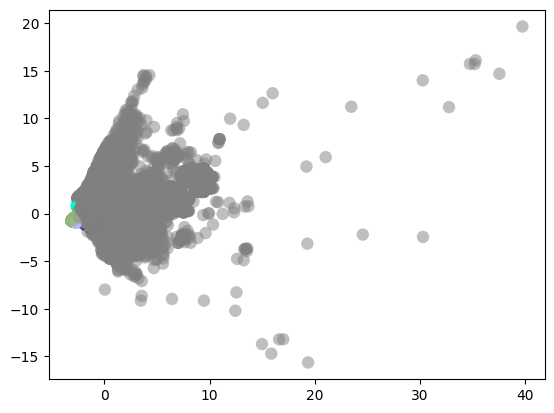

In [682]:
plt.scatter(res_pca_vis[:,0], res_pca_vis[:,1], c=cluster_colors_OPTICS, **plot_kwds)

#### Plot 3D

In [683]:
pca_vis3d = PCA(n_components=3)

In [684]:
pca_vis3d.fit(selected_usage_normalized)

PCA(n_components=3)

In [685]:
res_pca_vis3d = pca_vis3d.transform(selected_usage_normalized)

In [686]:
res_pca_vis3d.shape

(100001, 3)

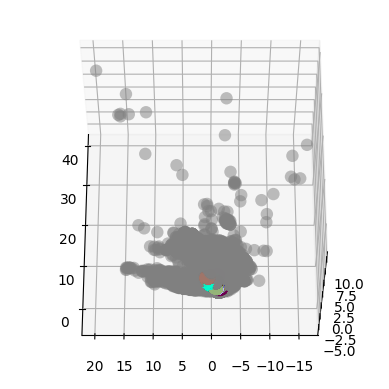

In [912]:
ax = plt.axes(projection='3d')
ax.scatter(res_pca_vis3d[:,0], res_pca_vis3d[:,1], res_pca_vis3d[:,2], c=cluster_colors_OPTICS, **plot_kwds)
ax.view_init(60, -180)


## Generic analysis of Cluster algorithms

In [689]:
min_cluster_size = [5, 10, 20, 50, 100, 200, 300, 400, 600, 1_000, 2_000, 5_000]

In [690]:
from collections import defaultdict

In [696]:
HDBSCAN_analysis = defaultdict(list)

for min_cl_size in min_cluster_size:
    print("Processing cl_size %i" % min_cl_size)
    alg = hdbscan.HDBSCAN(min_cluster_size=min_cl_size, metric='manhattan')
    alg.fit_predict(selected_usage_normalized)
    # cl_size
    HDBSCAN_analysis['min_cluster_size'].append(min_cl_size)
    # outliers
    HDBSCAN_analysis['n_outliers'].append(np.count_nonzero(alg.labels_ == -1))
    # n clusters
    HDBSCAN_analysis['n_clusters'].append(np.max(alg.labels_)+1)
    #mean cluster size
    HDBSCAN_analysis['mean_cluster_size'].append(np.mean([np.count_nonzero(alg.labels_ == i) for i in range(np.max(alg.labels_)+1)]))
    # avg silhouette
    if max(alg.labels_) > 0:
        silh = silhouette_samples(selected_usage_normalized, alg.labels_, metric='manhattan')
        mask_alg = np.array([1 if x>-1 else 0 for x in alg.labels_])
        silh_masked = silh[mask_alg.astype(bool)]
        HDBSCAN_analysis['avg_silhouette'].append(silh_masked.mean())
    else:
        HDBSCAN_analysis['avg_silhouette'].append(1)
    

Processing cl_size 5
Processing cl_size 10
Processing cl_size 20
Processing cl_size 50
Processing cl_size 100
Processing cl_size 200
Processing cl_size 300
Processing cl_size 400
Processing cl_size 600
Processing cl_size 1000
Processing cl_size 2000
Processing cl_size 5000


/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  
/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  warnings.warn("Mean of empty slice.", RuntimeWarning, stacklevel=2)


In [ ]:
OPTICS_analysis = defaultdict(list)

for min_cl_size in min_cluster_size:
    print("Processing cl_size %i" % min_cl_size)
    alg = OPTICS(min_samples=min_cl_size, metric='manhattan')
    alg.fit_predict(selected_usage_normalized)
    # cl_size
    OPTICS_analysis['min_cluster_size'].append(min_cl_size)
    # outliers
    OPTICS_analysis['n_outliers'].append(np.count_nonzero(alg.labels_ == -1))
    # n clusters
    OPTICS_analysis['n_clusters'].append(np.max(alg.labels_)+1)
    #mean cluster size
    OPTICS_analysis['mean_cluster_size'].append(np.mean([np.count_nonzero(alg.labels_ == i) for i in range(np.max(alg.labels_)+1)]))
    # avg silhouette
    if max(alg.labels_) > 0:
        silh = silhouette_samples(selected_usage_normalized, alg.labels_, metric='manhattan')
        mask_alg = np.array([1 if x>-1 else 0 for x in alg.labels_])
        silh_masked = silh[mask_alg.astype(bool)]
        OPTICS_analysis['avg_silhouette'].append(silh_masked.mean())
    else:
        OPTICS_analysis['avg_silhouette'].append(1)
    

Processing cl_size 5


/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Processing cl_size 10


In [846]:
OPTICS_analysis_df = pd.DataFrame(OPTICS_analysis)
OPTICS_analysis_df.at[11, 'avg_silhouette'] = -1

In [847]:
OPTICS_analysis_df

min_cluster_size  n_outliers  n_clusters  mean_cluster_size  \
0                  5       53534        5585           8.319964   
1                 10       66216        1866          18.105573   
2                 20       71066         694          41.693084   
3                 50       73178         211         127.123223   
4                100       73758         107         245.261682   
5                200       79087          44         475.318182   
6                300       81080          25         756.840000   
7                400       82145          16        1116.000000   
8                600       86079           9        1546.888889   
9               1000       89181           4        2705.000000   
10              2000       93963           2        3019.000000   
11              5000           0           1      100001.000000   

    avg_silhouette  
0         0.562117  
1         0.586419  
2         0.625784  
3         0.667414  
4         0.659937  
5         0.680144  
6         0.709325  
7         0.676685  
8         0.707495  
9         0.682553  
10        0.669948  
11       -1.000000

In [848]:
HDBSCAN_analysis_df = pd.DataFrame(HDBSCAN_analysis)

In [849]:
HDBSCAN_analysis_df.at[11, 'mean_cluster_size'] = 0 
HDBSCAN_analysis_df.at[11, 'avg_silhouette'] = -1
HDBSCAN_analysis_df

min_cluster_size  n_outliers  n_clusters  mean_cluster_size  \
0                  5       26059        2539          29.122489   
1                 10       23319         950          80.717895   
2                 20       26597         469         156.511727   
3                 50       30755         197         351.502538   
4                100       38474         122         504.319672   
5                200       42254          52        1110.519231   
6                300       42622          27        2125.148148   
7                400       44416          20        2779.250000   
8                600       50483          16        3094.875000   
9               1000       57727          13        3251.846154   
10              2000       57875           5        8425.200000   
11              5000      100001           0           0.000000   

    avg_silhouette  
0         0.300489  
1         0.326507  
2         0.383850  
3         0.439077  
4         0.467965  
5         0.467021  
6         0.499980  
7         0.513715  
8         0.533173  
9         0.536291  
10        0.517041  
11       -1.000000

### Some HDBSCAN findings

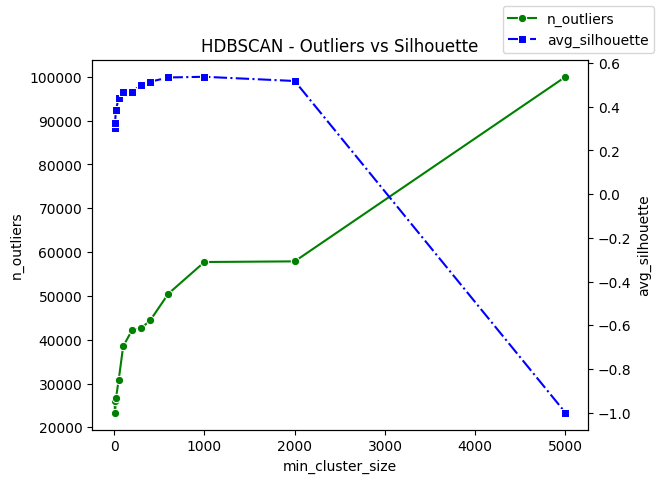

In [850]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.n_outliers, color="g", linestyle="-", marker="o", label='n_outliers', ax=ax, legend=False)
ax2 = plt.twinx()
lns2 = sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.avg_silhouette, color="b", linestyle="-.", marker="s", label='avg_silhouette', ax=ax2, legend=False)

plt.title("HDBSCAN - Outliers vs Silhouette")

ax.figure.legend()

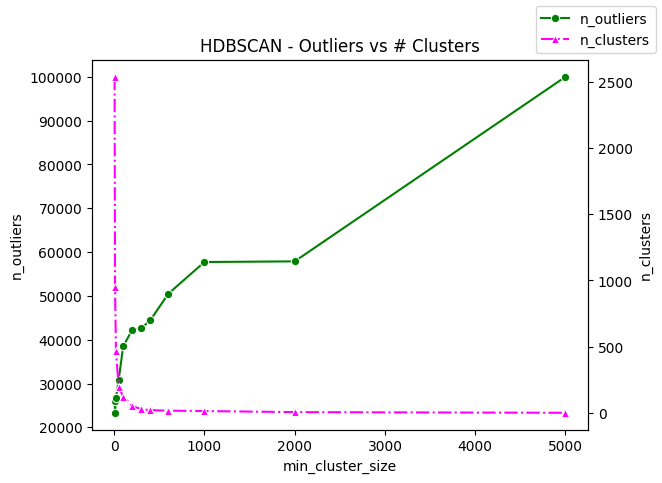

In [851]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.n_outliers, color="g", linestyle="-", marker="o", label='n_outliers', ax=ax, legend=False)
ax2 = plt.twinx()
lns2 = sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.n_clusters, color="magenta", linestyle="-.", marker="^", label='n_clusters', ax=ax2, legend=False)

plt.title("HDBSCAN - Outliers vs # Clusters")

ax.figure.legend()

### Some OPTICS findings

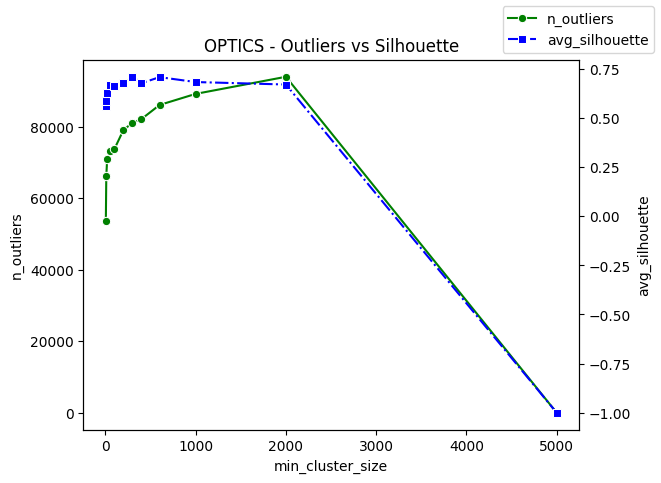

In [852]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.n_outliers, color="g", linestyle="-", label='n_outliers', marker="o", ax=ax, legend=False)
ax2 = plt.twinx()
lns2 = sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.avg_silhouette, color="b", linestyle="-.", label='avg_silhouette', marker="s", ax=ax2, legend=False)

plt.title("OPTICS - Outliers vs Silhouette")

ax.figure.legend()

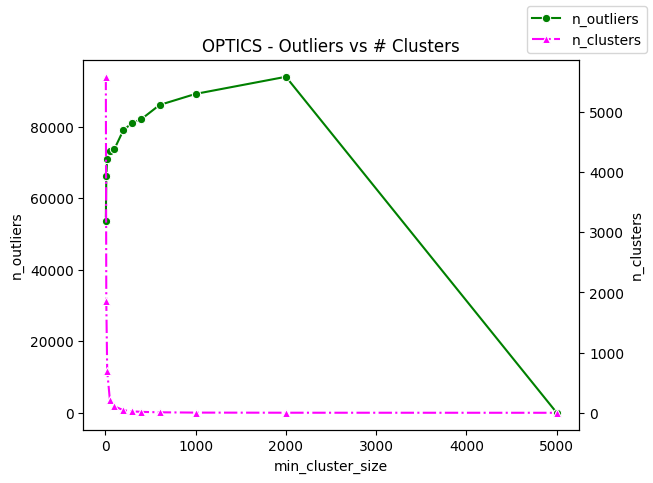

In [853]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.n_outliers, color="g", linestyle="-", label='n_outliers', ax=ax, marker="o", legend=False)
ax2 = plt.twinx()
lns2 = sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.n_clusters, color="magenta", linestyle="-.", label='n_clusters', ax=ax2, marker="^", legend=False)

plt.title("OPTICS - Outliers vs # Clusters")

ax.figure.legend()

### Build weighted scoring

In [757]:
1 - ((abs(26 - 26)) / max([26, 26]))

1.0

In [758]:
silh = 0.533173

In [759]:
outl = 1 - (50483/100_001)

In [760]:
outl

0.4951750482495175

In [791]:
1 - ((abs(26 - 1)) / max([26, 1]))

0.038461538461538436

In [762]:
cl_size

0.6153846153846154

In [764]:
silh + cl_size + outl

0.5479108878780443

In [766]:
def cl_size_score(optimal_cluster_size, actual_cluster_size):
    return 1 - ((abs(optimal_cluster_size - actual_cluster_size)) / max([optimal_cluster_size, actual_cluster_size]))

In [767]:
def outlier_score(n_outliers, dataset_size):
    return 1 - (n_outliers/dataset_size)

In [822]:
def weighted_scoring(scores, weights=None):
    score=0
    # if there are specifically designed weights
    if weights:
        if len(scores) != len(weights):
            print("The number of weights have to match the number of scores")
            return
        else:
            for i in range(len(scores)):
                score += scores[i] * weights[i]
    # Otherwise, we define an equal weight for each score
    else:
        weight = 1.0 / len(scores)
        for i in range(len(scores)):
            score += (scores[i] * weight)
    return score

### Score v1 - no weights

In [854]:
OPTICS_scores = []
for i in range(len(OPTICS_analysis_df)):
    experiment_scores = []
    experiment_scores.append(OPTICS_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=OPTICS_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=OPTICS_analysis_df.n_outliers.values[i], dataset_size=100_001))
    OPTICS_scores.append(weighted_scoring(experiment_scores))
OPTICS_scores

[0.34381264178214477,
 0.31273306462477124,
 0.317531824045292,
 0.35295466561321787,
 0.38845173206536343,
 0.4933968360793024,
 0.6200238591076562,
 0.49020911306501,
 0.39762253027614736,
 0.3148660468442009,
 0.26908354731797474,
 0.01282051282051283]

In [855]:
HDBSCAN_scores = []
for i in range(len(HDBSCAN_analysis_df)):
    experiment_scores = []
    experiment_scores.append(HDBSCAN_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=HDBSCAN_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=HDBSCAN_analysis_df.n_outliers.values[i], dataset_size=100_001))
    HDBSCAN_scores.append(weighted_scoring(experiment_scores))
HDBSCAN_scores

[0.35004742476179873,
 0.3735625414323087,
 0.3911067067920165,
 0.4211698917294435,
 0.4321144017585032,
 0.5148284931632701,
 0.678909078659472,
 0.6129301579425165,
 0.5479110435678407,
 0.4863422542288909,
 0.3768682065488176,
 -0.3333333333333333]

In [856]:
HDBSCAN_analysis_df['scores_v1'] = HDBSCAN_scores

In [857]:
OPTICS_analysis_df['scores_v1'] = OPTICS_scores

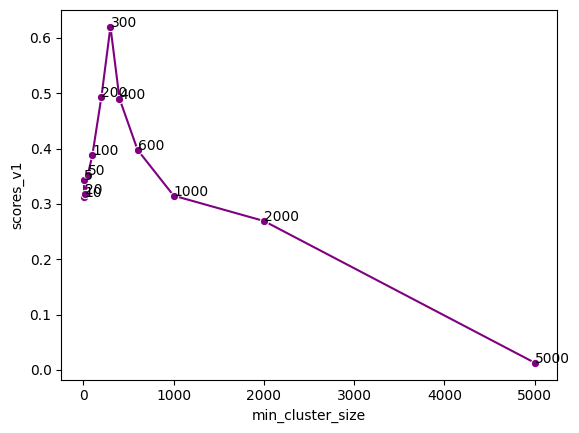

In [858]:
sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.scores_v1, color="purple", linestyle="-", marker="o")
for x, y in zip(OPTICS_analysis_df.min_cluster_size, OPTICS_analysis_df.scores_v1):
    plt.text(x = x, y = y, s = '{:.0f}'.format(x))

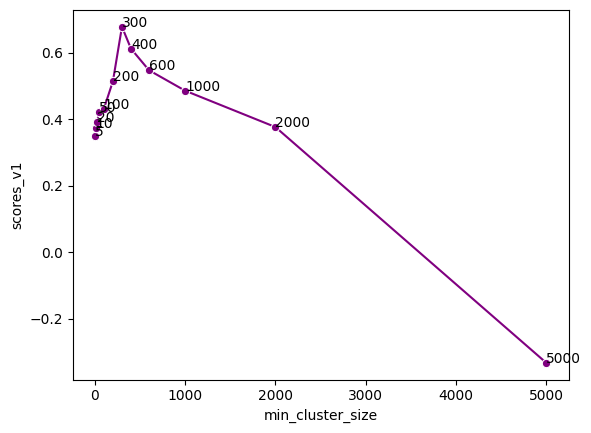

In [859]:
sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.scores_v1, color="purple", linestyle="-", marker="o")
for x, y in zip(HDBSCAN_analysis_df.min_cluster_size, HDBSCAN_analysis_df.scores_v1):
    plt.text(x = x, y = y, s = '{:.0f}'.format(x))

### Score v2 - silh_score 0.3, n_clusters_score 0.3, n_outliers_score 0.4

In [860]:
OPTICS_scores_v2 = []
for i in range(len(OPTICS_analysis_df)):
    experiment_scores = []
    experiment_scores.append(OPTICS_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=OPTICS_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=OPTICS_analysis_df.n_outliers.values[i], dataset_size=100_001))
    OPTICS_scores_v2.append(weighted_scoring(experiment_scores, [0.3, 0.3, 0.4]))
OPTICS_scores_v2

[0.355897912938577,
 0.31524442031567257,
 0.31471335229365627,
 0.3444819308245784,
 0.3758492964314514,
 0.46497094333346356,
 0.5769422839887828,
 0.4590440232002946,
 0.37178213802992477,
 0.2941993339608628,
 0.24821313220678107,
 0.11153846153846159]

In [861]:
HDBSCAN_scores_v2 = []
for i in range(len(HDBSCAN_analysis_df)):
    experiment_scores = []
    experiment_scores.append(HDBSCAN_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=HDBSCAN_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=HDBSCAN_analysis_df.n_outliers.values[i], dataset_size=100_001))
    HDBSCAN_scores_v2.append(weighted_scoring(experiment_scores, [0.3, 0.3, 0.4]))
HDBSCAN_scores_v2

[0.38898394287301297,
 0.41288752047674604,
 0.4253993020801552,
 0.4482982101034237,
 0.45042934631880555,
 0.5210920663827178,
 0.6683965970092627,
 0.6072215863038233,
 0.5426374440360084,
 0.4799816060702292,
 0.3813069646381484,
 -0.3]

In [862]:
HDBSCAN_analysis_df['scores_v2'] = HDBSCAN_scores_v2

In [863]:
OPTICS_analysis_df['scores_v2'] = OPTICS_scores_v2

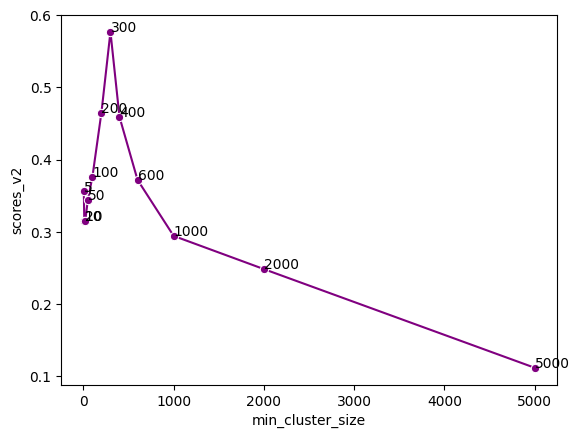

In [864]:
sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.scores_v2, color="purple", linestyle="-", marker="o")
for x, y in zip(OPTICS_analysis_df.min_cluster_size, OPTICS_analysis_df.scores_v2):
    plt.text(x = x, y = y, s = '{:.0f}'.format(x))

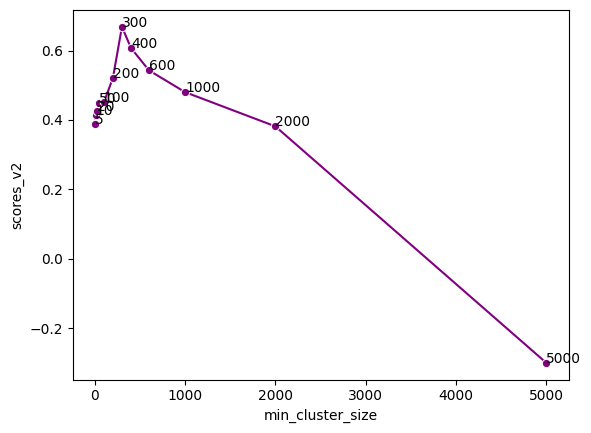

In [865]:
sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.scores_v2, color="purple", linestyle="-", marker="o")
for x, y in zip(HDBSCAN_analysis_df.min_cluster_size, HDBSCAN_analysis_df.scores_v2):
    plt.text(x = x, y = y, s = '{:.0f}'.format(x))

### Score v2 - silh_score 0.4, n_clusters_score 0.1, n_outliers_score 0.5

In [866]:
OPTICS_scores_v3 = []
for i in range(len(OPTICS_analysis_df)):
    experiment_scores = []
    experiment_scores.append(OPTICS_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=OPTICS_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=OPTICS_analysis_df.n_outliers.values[i], dataset_size=100_001))
    OPTICS_scores_v3.append(weighted_scoring(experiment_scores, [0.4, 0.1, 0.5]))
OPTICS_scores_v3

[0.45764510744278175,
 0.4048842753944223,
 0.3987337064236704,
 0.413401505863994,
 0.4194876197893782,
 0.43571726688452705,
 0.4744879032595412,
 0.42149137250441304,
 0.38722274326661515,
 0.34250530186027695,
 0.3058612733252504,
 0.10384615384615381]

In [867]:
HDBSCAN_scores_v3 = []
for i in range(len(HDBSCAN_analysis_df)):
    experiment_scores = []
    experiment_scores.append(HDBSCAN_analysis_df.avg_silhouette.values[i])
    experiment_scores.append(cl_size_score(optimal_cluster_size=26, actual_cluster_size=HDBSCAN_analysis_df.n_clusters.values[i]))
    experiment_scores.append(outlier_score(n_outliers=HDBSCAN_analysis_df.n_outliers.values[i], dataset_size=100_001))
    HDBSCAN_scores_v3.append(weighted_scoring(experiment_scores, [0.4, 0.1, 0.5]))
HDBSCAN_scores_v3

[0.4909260946812296,
 0.5167457565906491,
 0.5261001840537942,
 0.5350552689928152,
 0.5161292406168483,
 0.5255406143316987,
 0.5831804317182154,
 0.5603314029173476,
 0.522395372490976,
 0.47588428233889646,
 0.43667511891048605,
 -0.4]

In [868]:
HDBSCAN_analysis_df['scores_v3'] = HDBSCAN_scores_v3

In [869]:
OPTICS_analysis_df['scores_v3'] = OPTICS_scores_v3

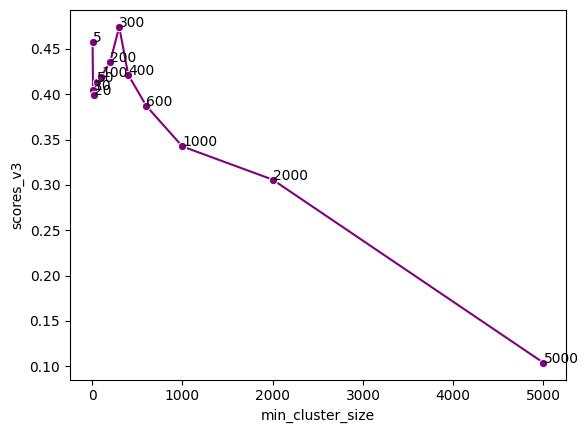

In [870]:
sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.scores_v3, color="purple", linestyle="-", marker="o")
for x, y in zip(OPTICS_analysis_df.min_cluster_size, OPTICS_analysis_df.scores_v3):
    plt.text(x = x, y = y, s = '{:.0f}'.format(x))

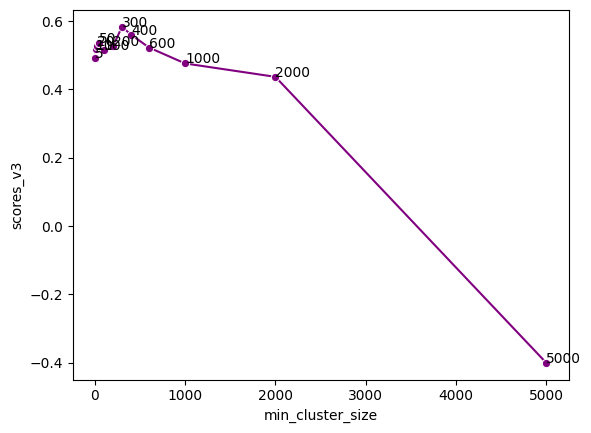

In [871]:
sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.scores_v3, color="purple", linestyle="-", marker="o")
for x, y in zip(HDBSCAN_analysis_df.min_cluster_size, HDBSCAN_analysis_df.scores_v3):
    plt.text(x = x, y = y, s = '{:.0f}'.format(x))

## Measure cluster tendency

### Hopkins test

A statistical test which allow to guess if the data follow an uniform distribution. If the test is positve (an **hopkins score which tends to 0**) it means that the **data is not uniformly distributed**. Hence **clustering can be useful** to classify the observations. However, if the score is too high (above 0.3 for exemple); the data is uniformly distributed and clustering can’t be really useful for the problem at hand.

https://pyclustertend.readthedocs.io/en/master/

In [794]:
from sklearn import datasets

In [796]:
from sklearn.preprocessing import scale

In [804]:
from pyclustertend import hopkins

In [805]:
hopkins(selected_usage_normalized, selected_usage_normalized.shape[0])

0.003348442272873262

In [808]:
from sklearn.metrics import davies_bouldin_score

In [810]:
davies_bouldin_score(selected_usage_normalized, labels=clusterer.labels_)

1.6842540017510539

In [811]:
1 / 1.6842540017510539

0.5937346736064386

## Try Self Organizing Maps

In [873]:
from sklearn_som.som import SOM

In [878]:
clusterer_som = SOM(m=5, n=5, dim=17)

In [879]:
clusterer_som.fit(selected_usage_normalized)

In [881]:
som_predictions = clusterer_som.predict(selected_usage_normalized)

In [884]:
set(som_predictions)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24}

In [885]:
silhouette_som = silhouette_samples(selected_usage_normalized, som_predictions)

In [886]:
silhouette_som.mean()

0.14150474079590464

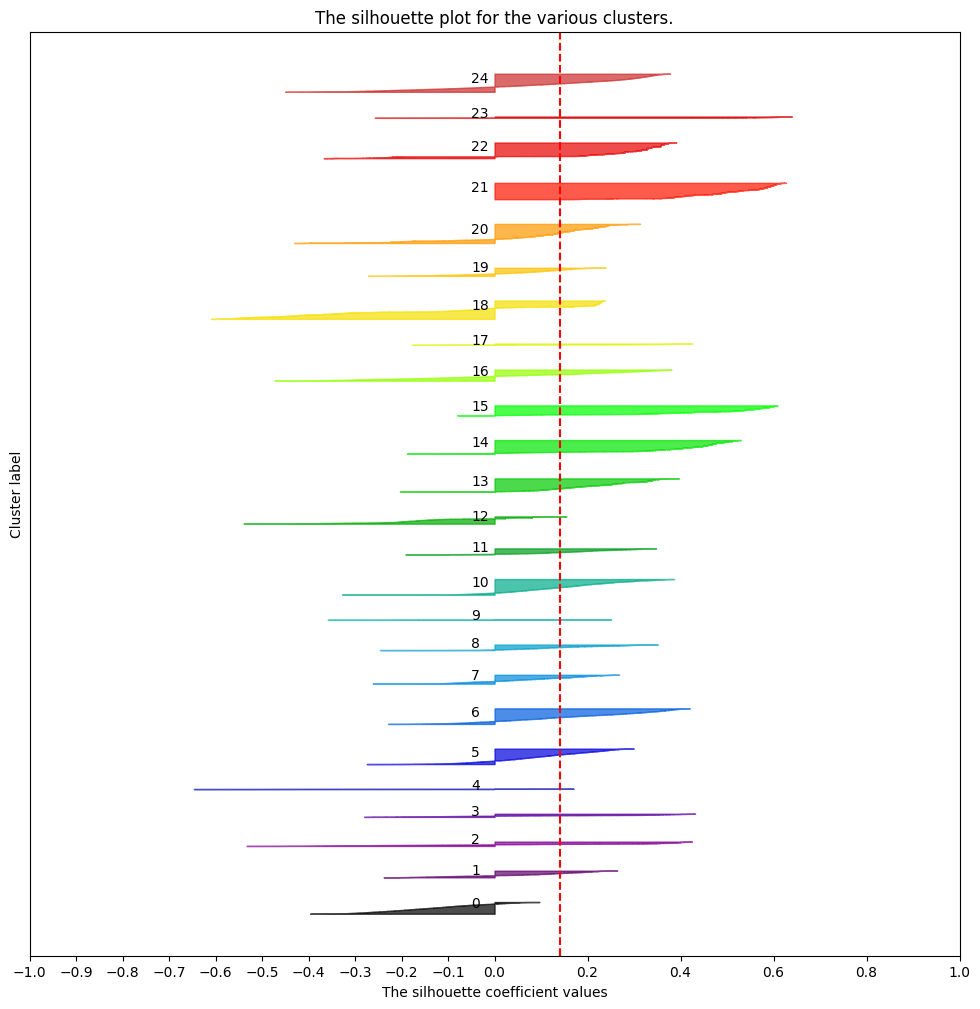

In [887]:
plot_silhouette_results(som_predictions, silhouette_som.mean(), silhouette_som, len(set(som_predictions)), multiplier=10000)

## Try using CURE

In [889]:
from pyclustering.cluster.cure import cure

In [901]:
cure_instance = cure(selected_usage_normalized, 26, compression=0.7)

In [902]:
cure_instance.process()
clusters = cure_instance.get_clusters()

In [903]:
for i, cl in enumerate(clusters):
    print("cluster %i - %i" % (i, len(cl)))

cluster 0 - 99599
cluster 1 - 41
cluster 2 - 12
cluster 3 - 24
cluster 4 - 3
cluster 5 - 2
cluster 6 - 2
cluster 7 - 6
cluster 8 - 1
cluster 9 - 14
cluster 10 - 11
cluster 11 - 1
cluster 12 - 3
cluster 13 - 4
cluster 14 - 2
cluster 15 - 3
cluster 16 - 2
cluster 17 - 236
cluster 18 - 1
cluster 19 - 2
cluster 20 - 26
cluster 21 - 1
cluster 22 - 1
cluster 23 - 1
cluster 24 - 2
cluster 25 - 1


## Try to cluster with HDBSCAN

In [920]:
clusterer_hdbscan = hdbscan.HDBSCAN(min_cluster_size=300, metric='manhattan')

In [925]:
clusterer_hdbscan.fit_predict(selected_usage_normalized)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

(4.0, 0.0)

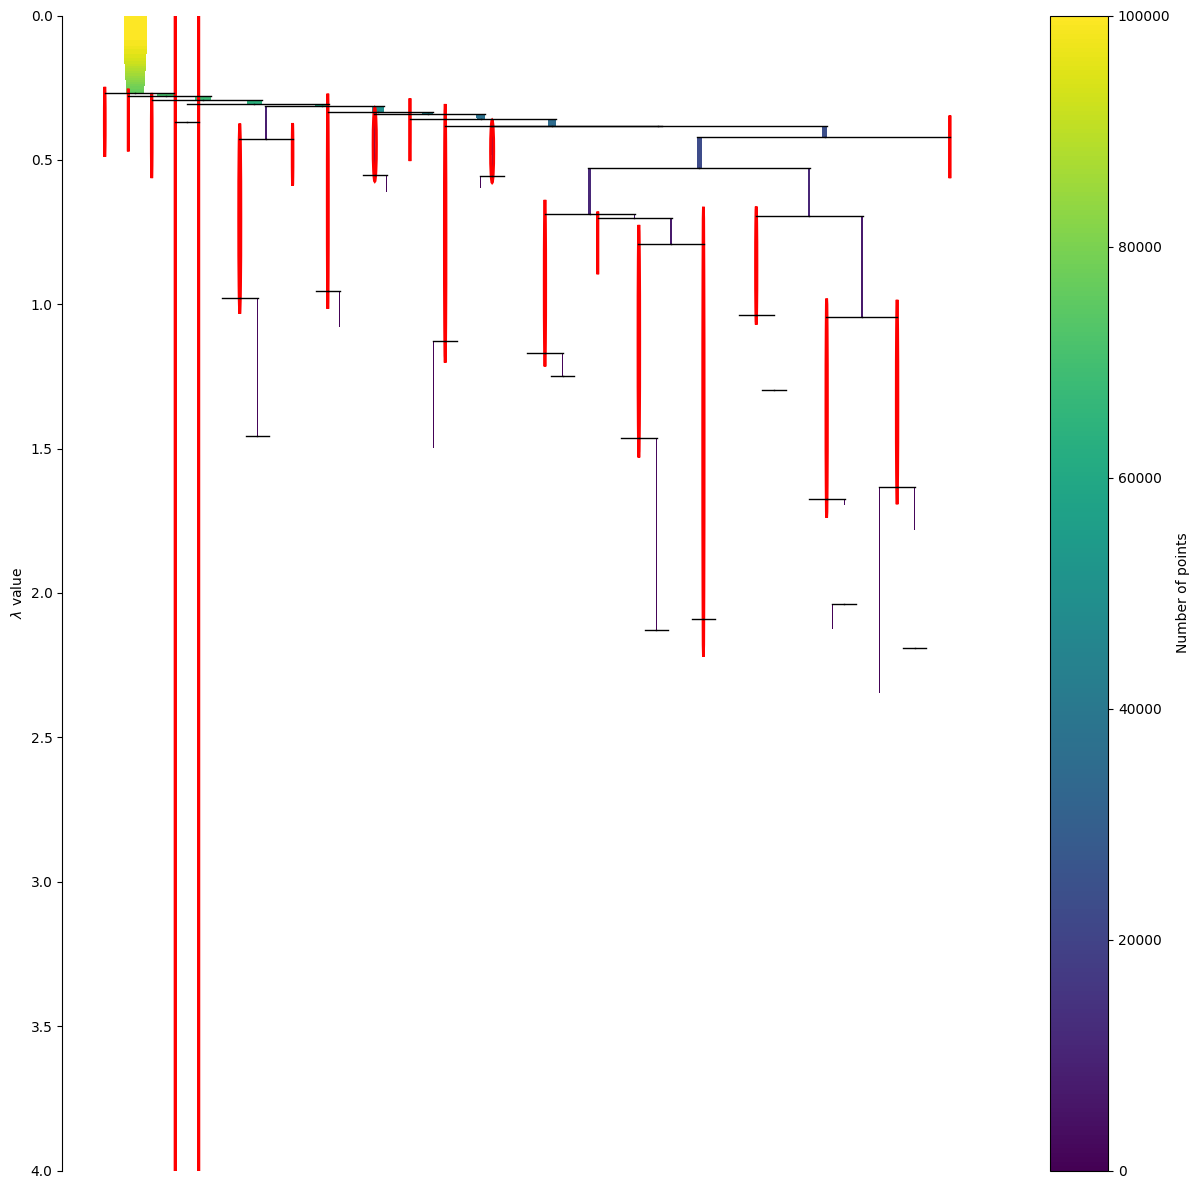

In [793]:
plt.figure(figsize=(15, 15))


clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

plt.ylim(4, 0)

### Analyze results

<AxesSubplot:ylabel='count'>

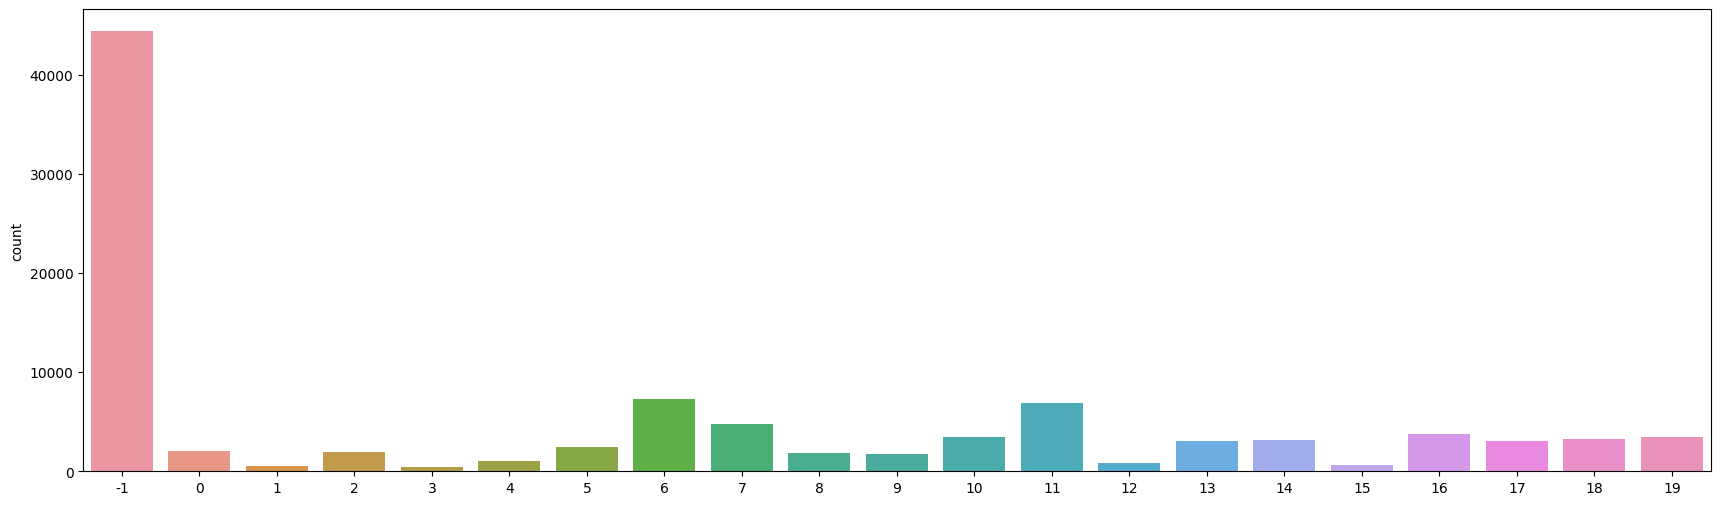

In [629]:
plt.figure(figsize=(21,6))
sns.countplot(x=clusterer.labels_)

In [630]:
clusterer.probabilities_

array([1.        , 0.8490256 , 0.80572888, ..., 0.        , 0.        ,
       0.        ])

In [631]:
import seaborn as sns, numpy as np

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


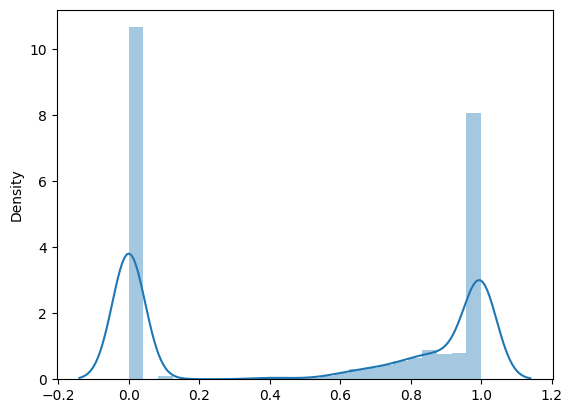

In [632]:
ax = sns.distplot(clusterer.probabilities_)

### Compute Silhouette

In [633]:
silhouette_HDBSCAN_400_manhattan = silhouette_samples(selected_usage_normalized, clusterer.labels_, metric='manhattan')

In [634]:
mask = np.array([1 if x>-1 else 0 for x in clusterer.labels_])
mask

array([1, 1, 1, ..., 0, 0, 0])

In [635]:
silhouette_masked = silhouette_HDBSCAN_400_manhattan[mask.astype(bool)]

In [636]:
silhouette_masked.mean()

0.5137152630411961

In [637]:
silhouette_HDBSCAN_400_manhattan

array([ 0.43391354,  0.54095412,  0.52755767, ..., -0.68400457,
       -0.58495965, -0.74082969])

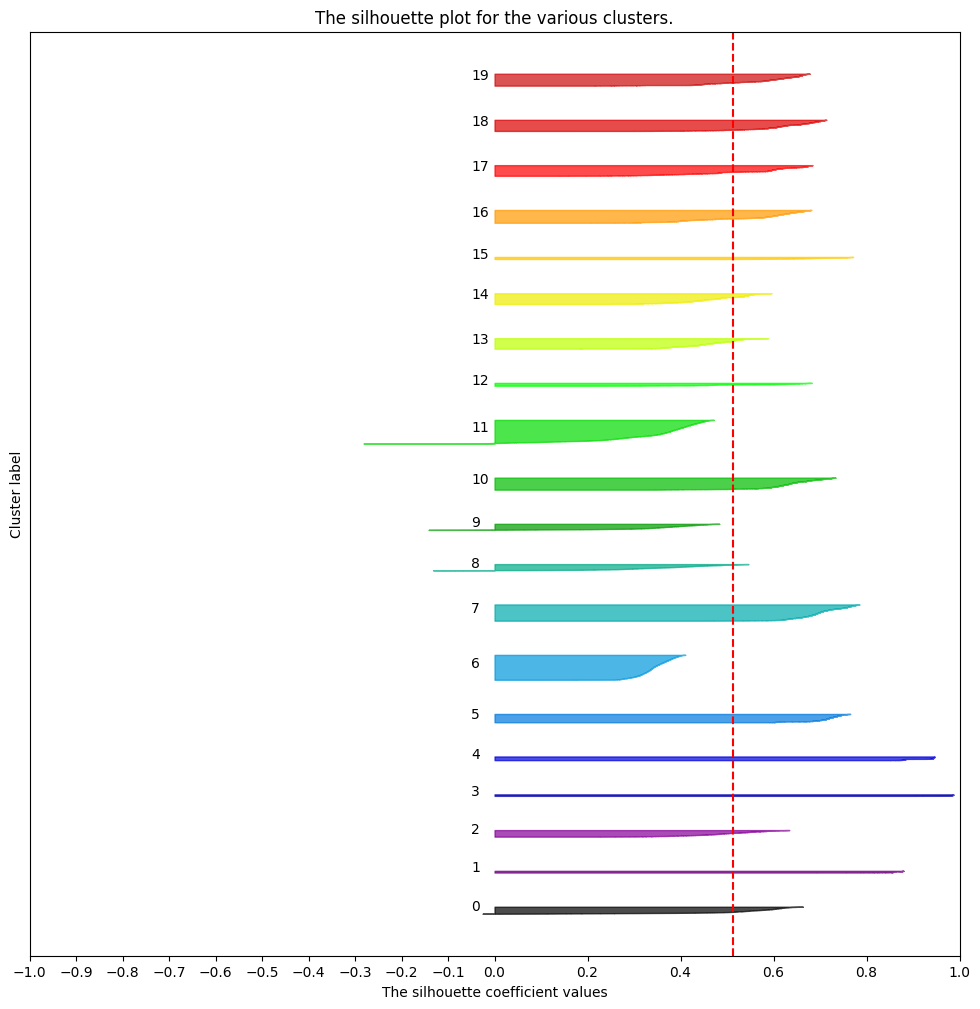

In [638]:
plot_silhouette_results(clusterer.labels_, silhouette_masked.mean(), silhouette_HDBSCAN_400_manhattan, max(clusterer.labels_) + 1, multiplier=10000)

### PCA for visualization

In [639]:
max(clusterer.labels_)

19

In [640]:
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=22)

plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [641]:

cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]

#### Plot 2D

In [642]:
pca_vis = PCA(n_components=2)

In [643]:
pca_vis.fit(selected_usage_normalized)

PCA(n_components=2)

In [644]:
res_pca_vis = pca_vis.transform(selected_usage_normalized)

In [645]:
res_pca_vis.shape

(100001, 2)

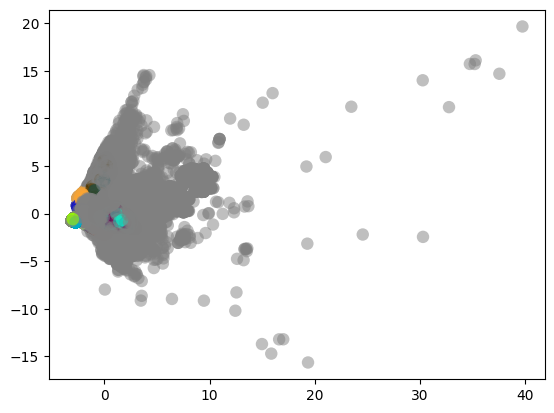

In [646]:
plt.scatter(res_pca_vis[:,0], res_pca_vis[:,1], c=cluster_colors, **plot_kwds)

#### Plot 3D

In [647]:
pca_vis3d = PCA(n_components=3)

In [648]:
pca_vis3d.fit(selected_usage_normalized)

PCA(n_components=3)

In [649]:
res_pca_vis3d = pca_vis3d.transform(selected_usage_normalized)

In [650]:
res_pca_vis3d.shape

(100001, 3)

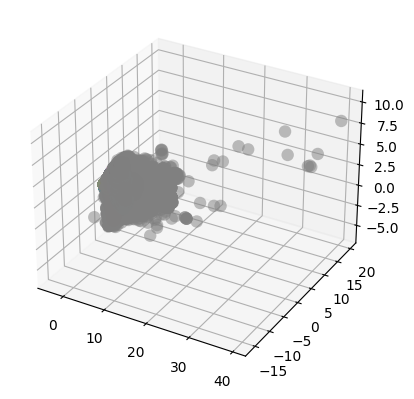

In [651]:
ax = plt.axes(projection='3d')
ax.scatter(res_pca_vis3d[:,0], res_pca_vis3d[:,1], res_pca_vis3d[:,2], c=cluster_colors, **plot_kwds)

### Analyze groups

In [652]:
from itertools import compress

In [653]:
results_hdbscan_400_manhattan_df = pd.DataFrame()

In [654]:
results_hdbscan_400_manhattan_df['labels'] = list(clusterer.labels_[mask.astype(bool)])

In [655]:
results_hdbscan_400_manhattan_df['workload'] = list(examples_sampled.workload[mask.astype(bool)])
results_hdbscan_400_manhattan_df['task_name'] = list(examples_sampled.task_name[mask.astype(bool)])
results_hdbscan_400_manhattan_df['group'] = list(examples_sampled.group[mask.astype(bool)])

In [656]:
results_hdbscan_400_manhattan_df

labels workload task_name                             group
0          19     bert        ps  02a6709662bff12fea88270e3eb1231d
1          19     bert        ps  02a6709662bff12fea88270e3eb1231d
2           0     bert    worker  8bc721404a5d34c9f68829312d324994
3          19     bert        ps  02a6709662bff12fea88270e3eb1231d
4          13     bert        ps  4ac7f9c48a6913dfa81169f7d6a150fa
...       ...      ...       ...                               ...
55580       4       rl    worker  e249e7ad3c89403a7e73ec9be36a5e49
55581       3       rl    worker  943107e34f0d22d9ace411b9a1431912
55582       3       rl    worker  943107e34f0d22d9ace411b9a1431912
55583       4       rl    worker  e249e7ad3c89403a7e73ec9be36a5e49
55584       4       rl    worker  e249e7ad3c89403a7e73ec9be36a5e49

[55585 rows x 4 columns]

<AxesSubplot:xlabel='labels', ylabel='count'>

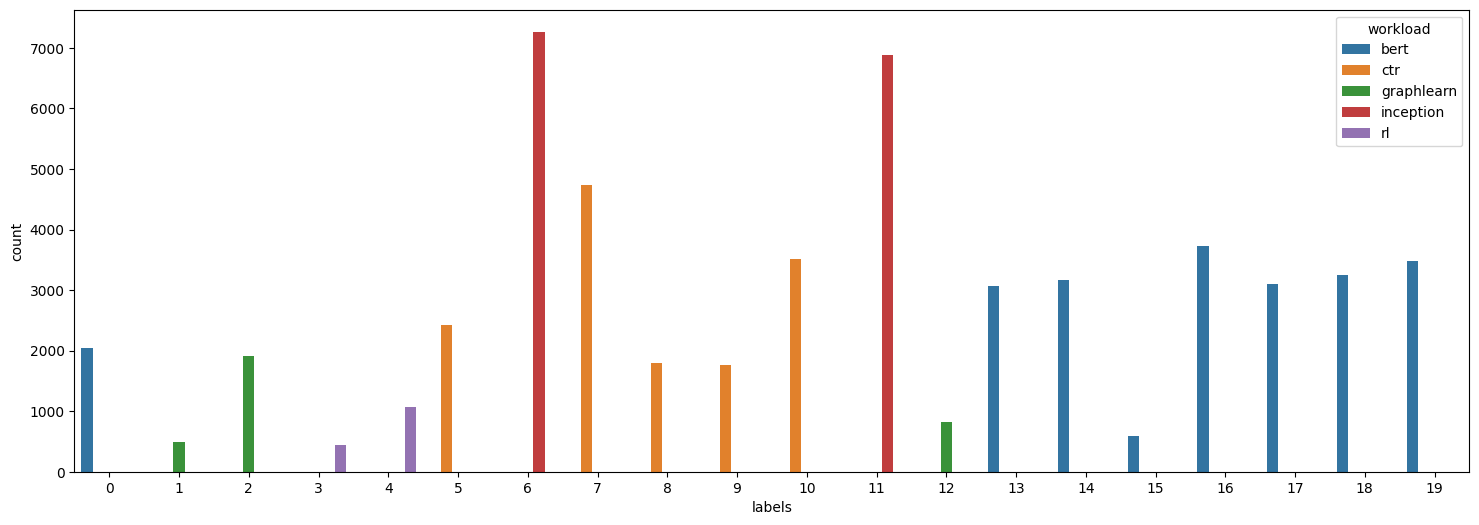

In [657]:
plt.figure(figsize=(18,6))
sns.countplot(x="labels", hue="workload", data=results_hdbscan_400_manhattan_df)

<AxesSubplot:xlabel='labels', ylabel='count'>

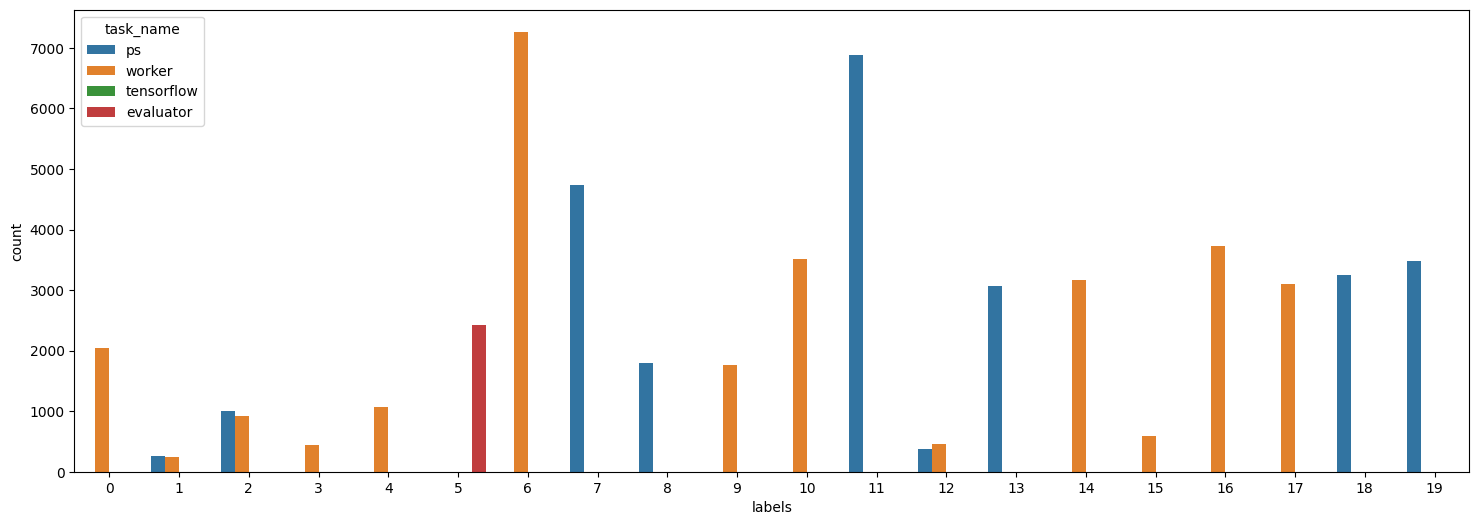

In [658]:
plt.figure(figsize=(18,6))
sns.countplot(x="labels", hue="task_name", data=results_hdbscan_400_manhattan_df)

In [659]:
results_hdbscan_400_manhattan_df['workload_task_name'] = list(compress(workload_task_name,mask.astype(bool)))

<AxesSubplot:xlabel='labels', ylabel='count'>

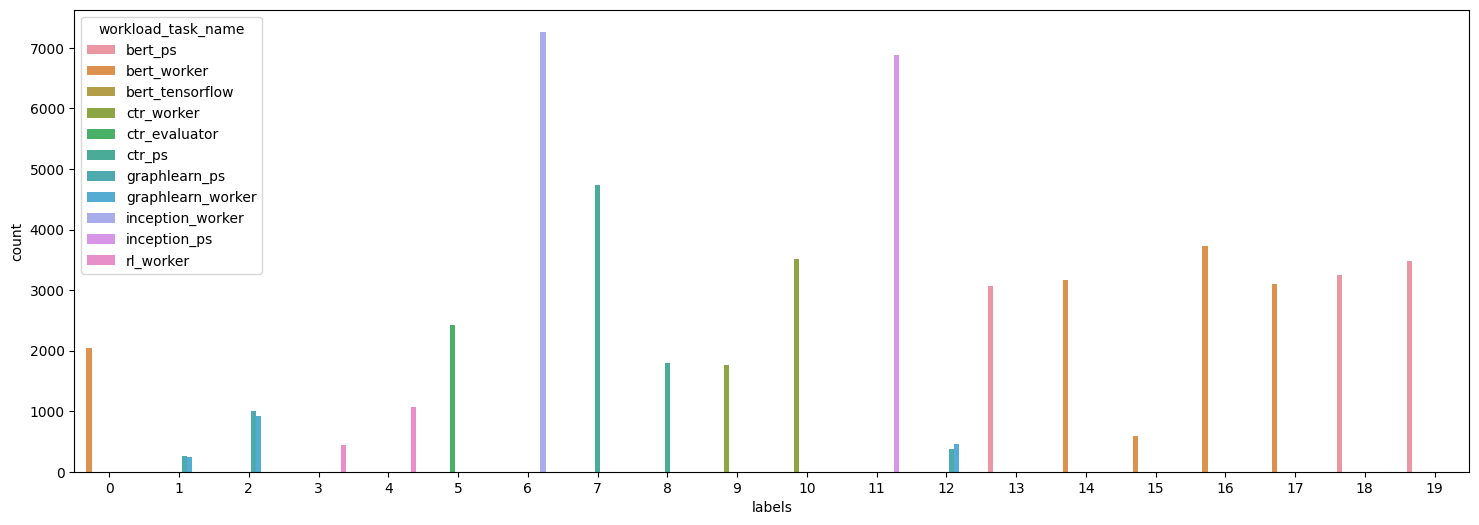

In [660]:
plt.figure(figsize=(18,6))
sns.countplot(x="labels", hue="workload_task_name", data=results_hdbscan_400_manhattan_df)

/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

<AxesSubplot:xlabel='avg_gpu_wrk_mem', ylabel='Density'>

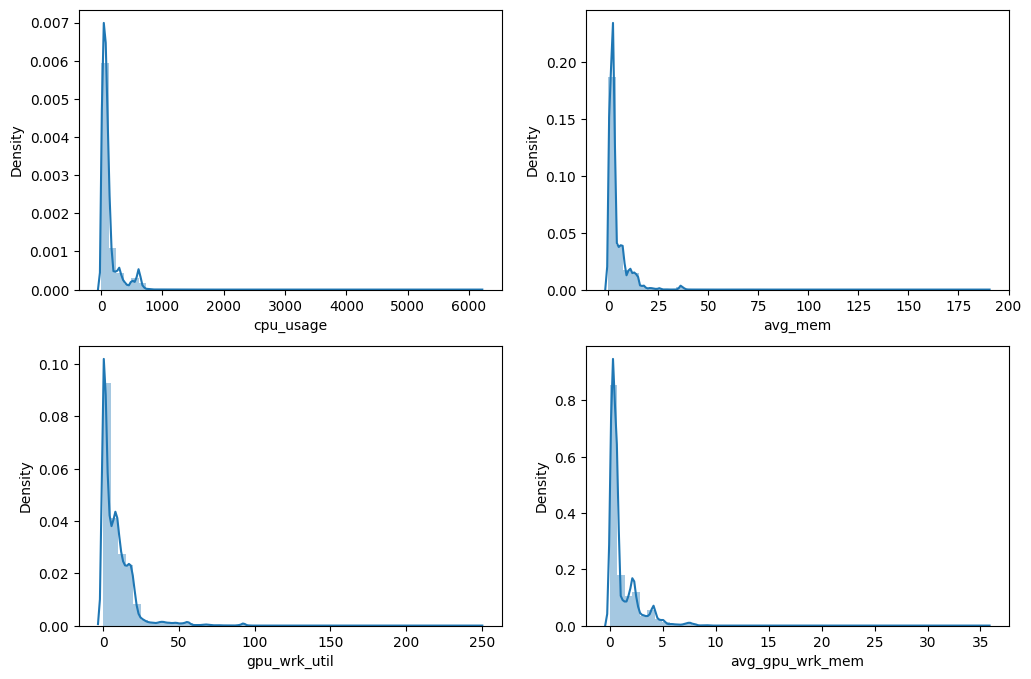

In [661]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.distplot(examples_sampled.cpu_usage, ax=axes[0, 0])
sns.distplot(examples_sampled.avg_mem, ax=axes[0, 1])
sns.distplot(examples_sampled.gpu_wrk_util, ax=axes[1, 0])
sns.distplot(examples_sampled.avg_gpu_wrk_mem, ax=axes[1, 1])
